In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a9408.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a1946.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a8141.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/h66.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a9001.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/h29.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a7351.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a7801.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a2852.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a8799.jpg
/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a201.jpg
/kag

In [2]:
import os, glob, random, math, time
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from tqdm import tqdm

SEED = 42
def seed_all(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_all()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

device(type='cuda')

In [3]:
DATASET_NAME_HINT = "/kaggle/input/liver-histopathology-fibrosis-ultrasound-images"
INPUT_ROOT = "/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset"

CLASS_NAMES = ["F0", "F1", "F2", "F3", "F4"]
CLASS_TO_ID = {c:i for i,c in enumerate(CLASS_NAMES)}

def find_data_root():
    # Search for a directory that contains F0..F4
    candidates = glob.glob(os.path.join(INPUT_ROOT, "**"), recursive=True)
    for c in candidates:
        if os.path.isdir(c):
            ok = all(os.path.isdir(os.path.join(c, k)) for k in CLASS_NAMES)
            if ok:
                return c
    return None

data_root = find_data_root()
print("Detected data root:", data_root)

assert data_root is not None, "Could not find folder containing F0..F4. Please check dataset paths."

def build_df(data_root):
    rows = []
    for cls in CLASS_NAMES:
        folder = os.path.join(data_root, cls)
        paths = glob.glob(os.path.join(folder, "*.jpg")) + glob.glob(os.path.join(folder, "*.JPG")) \
              + glob.glob(os.path.join(folder, "*.jpeg")) + glob.glob(os.path.join(folder, "*.png"))
        for p in paths:
            rows.append((p, CLASS_TO_ID[cls], cls))
    df = pd.DataFrame(rows, columns=["path", "label", "label_name"])
    return df

df = build_df(data_root)
print("Total images:", len(df))
df.head()


Detected data root: /kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/
Total images: 6323


,path,label,label_name
0,/kaggle/input/liver-histopathology-fibrosis-ul...,0,F0
1,/kaggle/input/liver-histopathology-fibrosis-ul...,0,F0
2,/kaggle/input/liver-histopathology-fibrosis-ul...,0,F0
3,/kaggle/input/liver-histopathology-fibrosis-ul...,0,F0
4,/kaggle/input/liver-histopathology-fibrosis-ul...,0,F0


label_name
F0    2114
F1     861
F2     793
F3     857
F4    1698
Name: count, dtype: int64

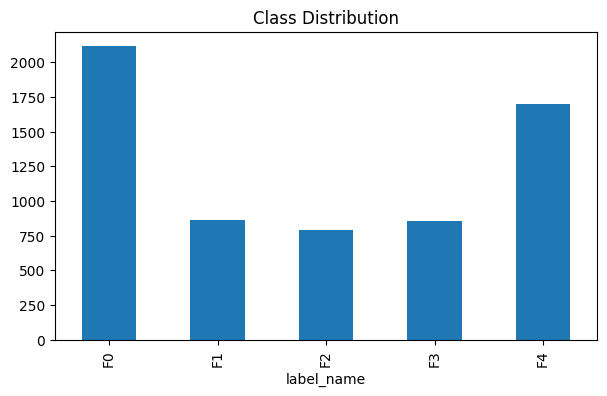

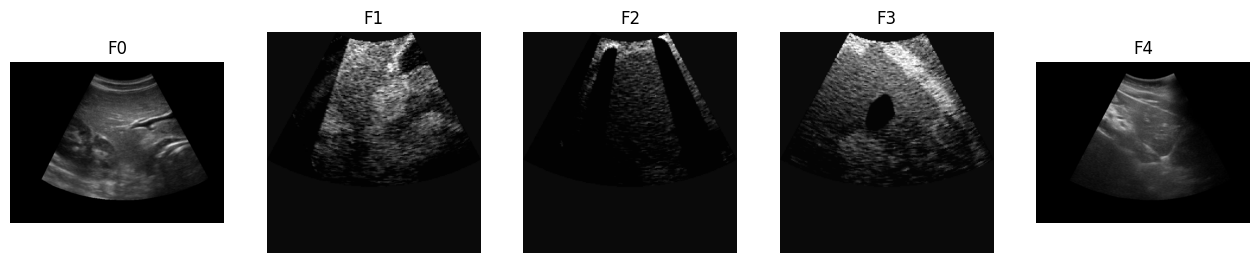

In [4]:
counts = df["label_name"].value_counts().reindex(CLASS_NAMES)
display(counts)

plt.figure(figsize=(7,4))
counts.plot(kind="bar")
plt.title("Class Distribution")
plt.show()

# Show sample images per class
fig, axes = plt.subplots(1, 5, figsize=(16, 4))
for i, cls in enumerate(CLASS_NAMES):
    p = df[df["label_name"] == cls].sample(1, random_state=SEED)["path"].values[0]
    img = Image.open(p).convert("RGB")
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis("off")
plt.show()


In [5]:
IMG_SIZE = 224

train_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Rotate(limit=7, p=0.5),
    A.RandomBrightnessContrast(p=0.35),
    A.GaussianBlur(blur_limit=(3,5), p=0.15),
    A.ElasticTransform(alpha=10, sigma=6, alpha_affine=6, p=0.15),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])


/tmp/ipykernel_55/4177745306.py:8: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=10, sigma=6, alpha_affine=6, p=0.15),


In [6]:
import cv2

class LiverFibrosisDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        y = int(row["label"])

        img = cv2.imread(path)
        if img is None:
            # fallback if cv2 fails
            img = np.array(Image.open(path).convert("RGB"))
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)["image"]

        return img, y


In [7]:
def build_model(model_name="efficientnet_b0", num_classes=5, pretrained=True):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    return model

def compute_class_weights(labels, num_classes=5):
    counts = np.bincount(labels, minlength=num_classes).astype(np.float32)
    weights = 1.0 / np.maximum(counts, 1.0)
    weights = weights / weights.sum() * num_classes
    return torch.tensor(weights, dtype=torch.float32)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)

        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(torch.argmax(probs, dim=1).cpu().numpy().tolist())
        y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")

    # One-vs-rest AUC (optional; can fail if a class missing in val fold)
    auc = None
    try:
        y_bin = label_binarize(y_true, classes=list(range(5)))
        auc = roc_auc_score(y_bin, y_prob, average="macro", multi_class="ovr")
    except:
        pass

    return acc, f1m, auc, y_true, y_pred, y_prob


In [8]:
from torch.cuda.amp import autocast, GradScaler

def train_one_fold(train_df, val_df,
                   model_name="efficientnet_b0",
                   epochs=6,
                   batch_size=32,
                   lr=3e-4,
                   use_weighted_sampler=True):

    train_ds = LiverFibrosisDataset(train_df, transform=train_tf)
    val_ds   = LiverFibrosisDataset(val_df,   transform=val_tf)

    # Handle imbalance
    if use_weighted_sampler:
        labels = train_df["label"].values
        class_counts = np.bincount(labels, minlength=5)
        sample_weights = 1.0 / np.maximum(class_counts[labels], 1)
        sampler = WeightedRandomSampler(
            weights=torch.tensor(sample_weights, dtype=torch.double),
            num_samples=len(sample_weights),
            replacement=True
        )
        train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler,
                                  num_workers=2, pin_memory=True)
    else:
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                                  num_workers=2, pin_memory=True)

    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=True)

    model = build_model(model_name=model_name, num_classes=5, pretrained=True).to(device)

    # loss with class weights (extra help for imbalance)
    class_w = compute_class_weights(train_df["label"].values, num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_w)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = GradScaler()

    best_f1 = -1
    best_state = None

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad(set_to_none=True)
            with autocast():
                logits = model(x)
                loss = criterion(logits, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * x.size(0)

        train_loss = running_loss / len(train_ds)

        acc, f1m, auc, y_true, y_pred, _ = evaluate(model, val_loader)
        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_acc={acc:.4f} | val_macroF1={f1m:.4f} | val_auc={auc}")

        if f1m > best_f1:
            best_f1 = f1m
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    model.load_state_dict(best_state)
    return model, best_f1



========== Fold 1/5 ==========


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/tmp/ipykernel_55/673706758.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=1.3423 | val_acc=0.7723 | val_macroF1=0.7166 | val_auc=0.9595964095721413


Epoch 2/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.5623 | val_acc=0.8957 | val_macroF1=0.8688 | val_auc=0.9861727151484262


Epoch 3/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.3699 | val_acc=0.7028 | val_macroF1=0.7113 | val_auc=0.9497697717306306


Epoch 4/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.2225 | val_acc=0.9328 | val_macroF1=0.9135 | val_auc=0.9945339543347769


Epoch 5/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.2148 | val_acc=0.9336 | val_macroF1=0.9209 | val_auc=0.9963218894296274


Epoch 6/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.2215 | val_acc=0.9502 | val_macroF1=0.9379 | val_auc=0.9972399740486015


Epoch 7/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1774 | val_acc=0.9771 | val_macroF1=0.9707 | val_auc=0.999101629898601


Epoch 8/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.1155 | val_acc=0.9794 | val_macroF1=0.9709 | val_auc=0.9992683409349847
Fold 1 Final | acc=0.9794 macroF1=0.9709 auc=0.9992683409349847

========== Fold 2/5 ==========


/tmp/ipykernel_55/673706758.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=1.3658 | val_acc=0.7146 | val_macroF1=0.6938 | val_auc=0.932839851559337


Epoch 2/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.4969 | val_acc=0.8735 | val_macroF1=0.8355 | val_auc=0.9831351008431323


Epoch 3/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.3597 | val_acc=0.9241 | val_macroF1=0.9014 | val_auc=0.9938379051800617


Epoch 4/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.2938 | val_acc=0.9660 | val_macroF1=0.9550 | val_auc=0.9975579608322734


Epoch 5/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.1794 | val_acc=0.9621 | val_macroF1=0.9515 | val_auc=0.9971085742610033


Epoch 6/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.1418 | val_acc=0.9668 | val_macroF1=0.9540 | val_auc=0.9977301492618847


Epoch 7/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1512 | val_acc=0.9810 | val_macroF1=0.9735 | val_auc=0.998849926528675


Epoch 8/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.1461 | val_acc=0.9779 | val_macroF1=0.9681 | val_auc=0.998719196380429


/tmp/ipykernel_55/673706758.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 Final | acc=0.9810 macroF1=0.9735 auc=0.998849926528675

========== Fold 3/5 ==========


Epoch 1/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=1.3487 | val_acc=0.7257 | val_macroF1=0.6710 | val_auc=0.9420820443486406


Epoch 2/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.6139 | val_acc=0.8949 | val_macroF1=0.8655 | val_auc=0.9855767563252964


Epoch 3/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.3951 | val_acc=0.9289 | val_macroF1=0.9102 | val_auc=0.9931342443696087


Epoch 4/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.3051 | val_acc=0.9660 | val_macroF1=0.9554 | val_auc=0.9984049550525345


Epoch 5/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.1712 | val_acc=0.9605 | val_macroF1=0.9475 | val_auc=0.9969190520058792


Epoch 6/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.1558 | val_acc=0.9676 | val_macroF1=0.9542 | val_auc=0.9965670020920205


Epoch 7/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1658 | val_acc=0.9779 | val_macroF1=0.9693 | val_auc=0.9970484629466055


Epoch 8/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.1491 | val_acc=0.9668 | val_macroF1=0.9562 | val_auc=0.9986217271707165


/tmp/ipykernel_55/673706758.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 Final | acc=0.9779 macroF1=0.9693 auc=0.9970484629466055

========== Fold 4/5 ==========


Epoch 1/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=1.3422 | val_acc=0.5356 | val_macroF1=0.5426 | val_auc=0.8777409301810082


Epoch 2/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.6398 | val_acc=0.8149 | val_macroF1=0.7798 | val_auc=0.9707983898019206


Epoch 3/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.4125 | val_acc=0.8687 | val_macroF1=0.8389 | val_auc=0.9835292798696018


Epoch 4/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.2973 | val_acc=0.9422 | val_macroF1=0.9192 | val_auc=0.9952948401024558


Epoch 5/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.2344 | val_acc=0.9509 | val_macroF1=0.9360 | val_auc=0.9966352137165491


Epoch 6/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.1566 | val_acc=0.9818 | val_macroF1=0.9741 | val_auc=0.9985350347646256


Epoch 7/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1257 | val_acc=0.9778 | val_macroF1=0.9688 | val_auc=0.9991544595832277


Epoch 8/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.1002 | val_acc=0.9818 | val_macroF1=0.9749 | val_auc=0.9989694915981093
Fold 4 Final | acc=0.9818 macroF1=0.9749 auc=0.9989694915981093

========== Fold 5/5 ==========


/tmp/ipykernel_55/673706758.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=1.3368 | val_acc=0.7112 | val_macroF1=0.6697 | val_auc=0.9229999383872425


Epoch 2/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.6224 | val_acc=0.9011 | val_macroF1=0.8771 | val_auc=0.9893234564189279


Epoch 3/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.3522 | val_acc=0.9201 | val_macroF1=0.8997 | val_auc=0.9924405501601828


Epoch 4/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.2348 | val_acc=0.9628 | val_macroF1=0.9510 | val_auc=0.9961401623931192


Epoch 5/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.1730 | val_acc=0.9565 | val_macroF1=0.9470 | val_auc=0.9976564584940419


Epoch 6/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.1722 | val_acc=0.9684 | val_macroF1=0.9572 | val_auc=0.9987292300407173


Epoch 7/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1639 | val_acc=0.9739 | val_macroF1=0.9643 | val_auc=0.9984950800657894


Epoch 8/8:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/673706758.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.1145 | val_acc=0.9739 | val_macroF1=0.9670 | val_auc=0.9977886132194822
Fold 5 Final | acc=0.9739 macroF1=0.9670 auc=0.9977886132194822

=== CV Summary ===
Mean acc    : 0.9788072246960524
Mean macroF1: 0.97111707677923
Mean AUC    : 0.9983849670455713

Classification Report (OOF):
              precision    recall  f1-score   support

          F0       1.00      1.00      1.00      2114
          F1       0.95      0.97      0.96       861
          F2       0.96      0.94      0.95       793
          F3       0.96      0.96      0.96       857
          F4       0.98      0.99      0.99      1698

    accuracy                           0.98      6323
   macro avg       0.97      0.97      0.97      6323
weighted avg       0.98      0.98      0.98      6323



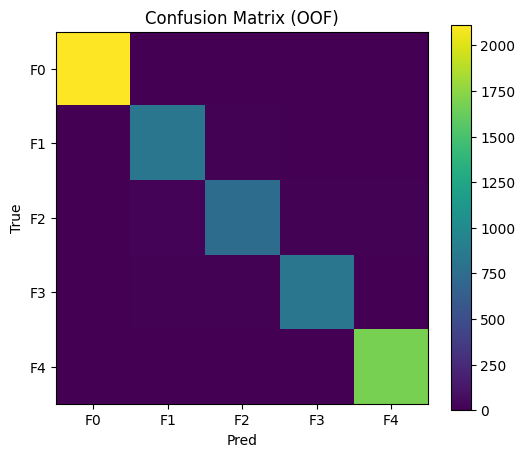

In [9]:
N_SPLITS = 5
EPOCHS = 8
BATCH_SIZE = 32
MODEL_NAME = "efficientnet_b0"   # you can try: "convnext_tiny", "resnet50", "vit_base_patch16_224"

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_scores = []
oof_true = np.zeros(len(df), dtype=int)
oof_pred = np.zeros(len(df), dtype=int)

for fold, (tr_idx, va_idx) in enumerate(skf.split(df, df["label"]), 1):
    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df   = df.iloc[va_idx].reset_index(drop=True)

    print(f"\n========== Fold {fold}/{N_SPLITS} ==========")
    model, best_f1 = train_one_fold(
        train_df, val_df,
        model_name=MODEL_NAME,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=3e-4,
        use_weighted_sampler=True
    )

    # Evaluate fold
    val_loader = DataLoader(LiverFibrosisDataset(val_df, val_tf), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    acc, f1m, auc, y_true, y_pred, y_prob = evaluate(model, val_loader)

    fold_scores.append((acc, f1m, auc))
    print(f"Fold {fold} Final | acc={acc:.4f} macroF1={f1m:.4f} auc={auc}")

    # store OOF
    oof_true[va_idx] = y_true
    oof_pred[va_idx] = y_pred

print("\n=== CV Summary ===")
fold_scores = np.array([[a, f, (c if c is not None else np.nan)] for a,f,c in fold_scores], dtype=float)
print("Mean acc    :", np.nanmean(fold_scores[:,0]))
print("Mean macroF1:", np.nanmean(fold_scores[:,1]))
print("Mean AUC    :", np.nanmean(fold_scores[:,2]))

print("\nClassification Report (OOF):")
print(classification_report(oof_true, oof_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(oof_true, oof_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix (OOF)")
plt.xticks(range(5), CLASS_NAMES)
plt.yticks(range(5), CLASS_NAMES)
plt.colorbar()
plt.xlabel("Pred")
plt.ylabel("True")
plt.show()


In [10]:
# Train final model on full dataset (no validation)
full_ds = LiverFibrosisDataset(df, transform=train_tf)
labels = df["label"].values

# Weighted sampler
class_counts = np.bincount(labels, minlength=5)
sample_weights = 1.0 / np.maximum(class_counts[labels], 1)
sampler = WeightedRandomSampler(torch.tensor(sample_weights, dtype=torch.double),
                                num_samples=len(sample_weights), replacement=True)

full_loader = DataLoader(full_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)

model = build_model(MODEL_NAME, num_classes=5, pretrained=True).to(device)
class_w = compute_class_weights(labels, 5).to(device)
criterion = nn.CrossEntropyLoss(weight=class_w)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

model.train()
EPOCHS_FINAL = 10
for epoch in range(1, EPOCHS_FINAL+1):
    running = 0.0
    for x, y in tqdm(full_loader, desc=f"Final Train {epoch}/{EPOCHS_FINAL}", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running += loss.item()*x.size(0)
    print(f"Epoch {epoch} loss={running/len(full_ds):.4f}")

save_path = "/kaggle/working/liver_fibrosis_model.pth"
torch.save(model.state_dict(), save_path)
print("Saved:", save_path)


/tmp/ipykernel_55/3283339006.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Final Train 1/10:   0%|          | 0/198 [00:00<?, ?it/s]/tmp/ipykernel_55/3283339006.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 loss=1.2303


Epoch 2 loss=0.4920


Epoch 3 loss=0.2615


Epoch 4 loss=0.1667


Epoch 5 loss=0.1177


Epoch 6 loss=0.1028


Epoch 7 loss=0.0978


Epoch 8 loss=0.0742


Epoch 9 loss=0.0690


Epoch 10 loss=0.0588
Saved: /kaggle/working/liver_fibrosis_model.pth


Target layer: Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)


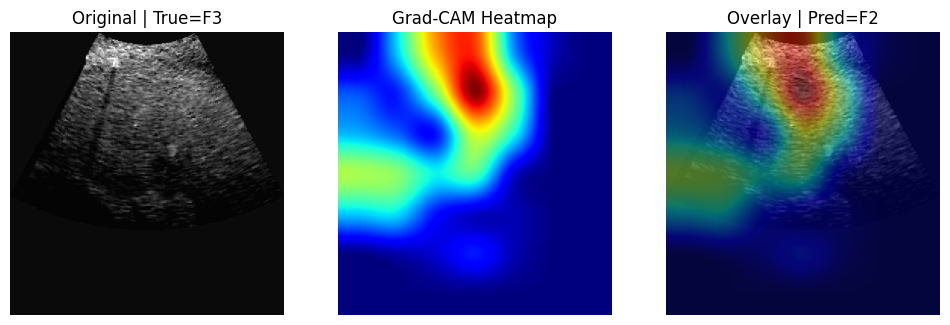

In [15]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        self.model.eval()
        x = x.to(device)

        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        self.model.zero_grad(set_to_none=True)
        score = logits[:, class_idx].sum()
        score.backward(retain_graph=True)

        # activations: [B,C,H,W], gradients: [B,C,H,W]
        grads = self.gradients
        acts  = self.activations

        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-6)
        cam = cam.squeeze().detach().cpu().numpy()

        return cam, class_idx
# Try to pick a reasonable last feature layer automatically for common backbones
def guess_target_layer(model):
    # EfficientNet/ConvNeXt/ResNet-like models usually have a final "conv" block
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, nn.Conv2d):
            return module
    return None

# Load trained model weights if needed
# model.load_state_dict(torch.load("/kaggle/working/liver_fibrosis_model.pth", map_location=device))

target_layer = guess_target_layer(model)
print("Target layer:", target_layer)

cam_explainer = GradCAM(model, target_layer)

# pick a random sample
sample_row = df.sample(1, random_state=SEED).iloc[0]
path = sample_row["path"]
true_label = sample_row["label_name"]

img_np = np.array(Image.open(path).convert("RGB"))
img_in = val_tf(image=img_np)["image"].unsqueeze(0)

cam, pred_idx = cam_explainer(img_in)
pred_label = CLASS_NAMES[pred_idx]

# Resize CAM to image size for visualization
cam_resized = np.array(Image.fromarray((cam*255).astype(np.uint8)).resize((img_np.shape[1], img_np.shape[0])))
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title(f"Original | True={true_label}")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cam_resized, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_np)
plt.imshow(cam_resized, cmap="jet", alpha=0.45)
plt.title(f"Overlay | Pred={pred_label}")
plt.axis("off")

plt.show()


In [12]:
@torch.no_grad()
def mc_dropout_predict(model, x, n_samples=20):
    model.train()  # enable dropout
    probs = []
    for _ in range(n_samples):
        logits = model(x.to(device))
        probs.append(torch.softmax(logits, dim=1).cpu().numpy())
    probs = np.stack(probs, axis=0)  # [S,B,C]
    mean = probs.mean(axis=0)
    std  = probs.std(axis=0)
    return mean, std

# Example on one image
model.eval()
img_in = val_tf(image=img_np)["image"].unsqueeze(0)
mean_prob, std_prob = mc_dropout_predict(model, img_in, n_samples=25)

print("Mean prob:", mean_prob[0])
print("Std  prob:", std_prob[0])
print("Pred:", CLASS_NAMES[int(mean_prob[0].argmax())], "Confidence:", float(mean_prob[0].max()))
print("Uncertainty (avg std):", float(std_prob[0].mean()))


Mean prob: [0.05423479 0.60451293 0.2554789  0.02513063 0.06064287]
Std  prob: [7.4505806e-09 1.7881393e-07 8.9406967e-08 5.5879354e-09 3.7252903e-09]
Pred: F1 Confidence: 0.6045129299163818
Uncertainty (avg std): 5.699694227701002e-08


**Resnet50******

Device: cuda
Detected data root: /kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/
Total images: 6323
label_name
F0    2114
F1     861
F2     793
F3     857
F4    1698
Name: count, dtype: int64
Train: 5058 | Val: 1265

Train distribution:
label_name
F0    1691
F1     689
F2     634
F3     686
F4    1358
Name: count, dtype: int64

Val distribution:
label_name
F0    423
F1    172
F2    159
F3    171
F4    340
Name: count, dtype: int64


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/tmp/ipykernel_55/3963728121.py:246: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3963728121.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=1.2533 | val_acc=0.5668 | val_macroF1=0.4956 | val_auc=0.8511697678697827


Epoch 2/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3963728121.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.7410 | val_acc=0.8261 | val_macroF1=0.7922 | val_auc=0.9587702831046249


Epoch 3/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3963728121.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.4443 | val_acc=0.9020 | val_macroF1=0.8794 | val_auc=0.9851582718037066


Epoch 4/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3963728121.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.2898 | val_acc=0.9036 | val_macroF1=0.8813 | val_auc=0.9909032975476405


Epoch 5/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3963728121.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.1806 | val_acc=0.9225 | val_macroF1=0.8901 | val_auc=0.9924699469340176


Epoch 6/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3963728121.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.1394 | val_acc=0.9668 | val_macroF1=0.9544 | val_auc=0.9956195197621884


Epoch 7/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3963728121.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1229 | val_acc=0.9700 | val_macroF1=0.9615 | val_auc=0.9957307803824629


Epoch 8/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3963728121.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.0957 | val_acc=0.9739 | val_macroF1=0.9645 | val_auc=0.9967584012403226


Epoch 9/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3963728121.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09 | train_loss=0.0974 | val_acc=0.9731 | val_macroF1=0.9643 | val_auc=0.9967388472441779


Epoch 10/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3963728121.py:266: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | train_loss=0.0600 | val_acc=0.9731 | val_macroF1=0.9645 | val_auc=0.9967559786560937

Best Val Macro F1: 0.9644979008202087

=== Final Validation Metrics ===
Accuracy : 0.9731
Macro F1 : 0.9645
AUC (OvR): 0.9967559786560937

=== Classification Report ===
              precision    recall  f1-score   support

          F0     0.9930    1.0000    0.9965       423
          F1     0.9760    0.9477    0.9617       172
          F2     0.9658    0.8868    0.9246       159
          F3     0.9341    0.9942    0.9632       171
          F4     0.9709    0.9824    0.9766       340

    accuracy                         0.9731      1265
   macro avg     0.9680    0.9622    0.9645      1265
weighted avg     0.9734    0.9731    0.9729      1265



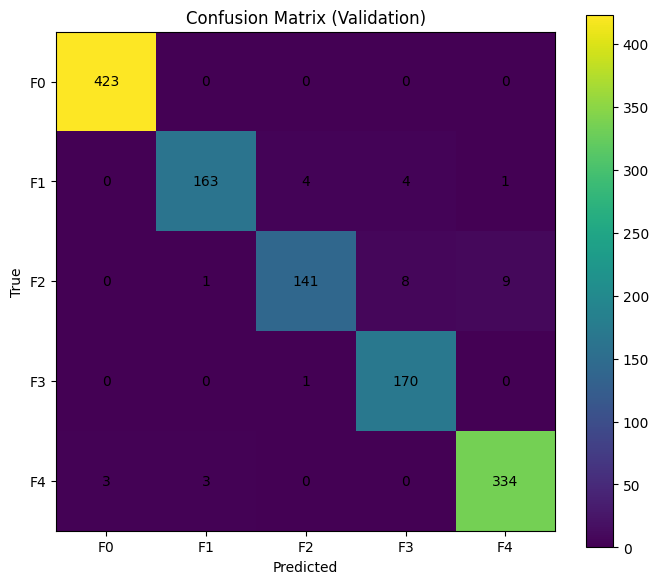

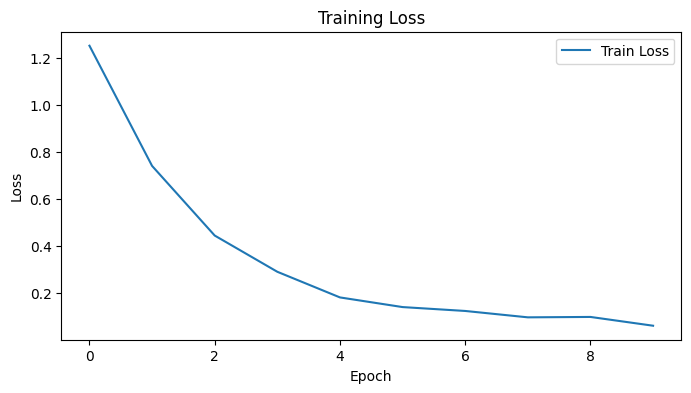

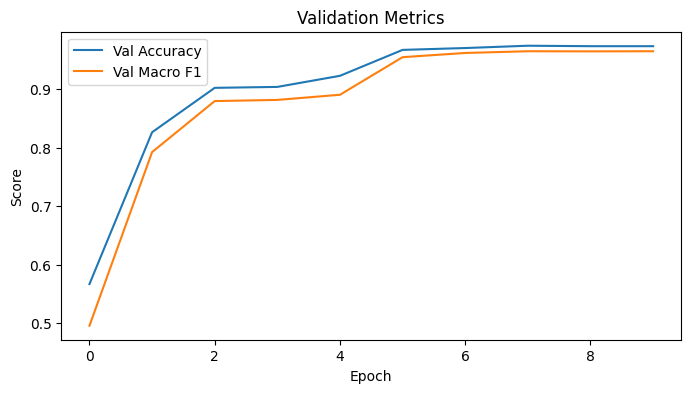

In [16]:
# =========================
# Liver Fibrosis Classification (ResNet, no CV)
# =========================

import os, glob, random
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from tqdm import tqdm

# -------------------------
# Config
# -------------------------
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LR = 3e-4
MODEL_NAME = "resnet50"   # try "resnet18", "resnet34", "resnet101"
VAL_SIZE = 0.2

INPUT_ROOT = "/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset"
CLASS_NAMES = ["F0", "F1", "F2", "F3", "F4"]
CLASS_TO_ID = {c: i for i, c in enumerate(CLASS_NAMES)}

# -------------------------
# Seed
# -------------------------
def seed_all(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True  # faster on fixed image sizes

seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Find dataset root
# -------------------------
def find_data_root(base_root):
    candidates = glob.glob(os.path.join(base_root, "**"), recursive=True)
    for c in candidates:
        if os.path.isdir(c):
            if all(os.path.isdir(os.path.join(c, cls)) for cls in CLASS_NAMES):
                return c
    return None

data_root = find_data_root(INPUT_ROOT)
print("Detected data root:", data_root)
assert data_root is not None, "Could not find folder containing F0..F4"

# -------------------------
# Build dataframe
# -------------------------
def build_df(data_root):
    rows = []
    for cls in CLASS_NAMES:
        folder = os.path.join(data_root, cls)
        paths = []
        for ext in ["*.jpg", "*.JPG", "*.jpeg", "*.png", "*.PNG", "*.JPEG"]:
            paths.extend(glob.glob(os.path.join(folder, ext)))
        for p in paths:
            rows.append((p, CLASS_TO_ID[cls], cls))
    df = pd.DataFrame(rows, columns=["path", "label", "label_name"])
    return df

df = build_df(data_root)
print("Total images:", len(df))
print(df["label_name"].value_counts().reindex(CLASS_NAMES))

# -------------------------
# Train/Val split (NO FOLDS)
# -------------------------
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SIZE,
    stratify=df["label"],
    random_state=SEED
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train: {len(train_df)} | Val: {len(val_df)}")
print("\nTrain distribution:")
print(train_df["label_name"].value_counts().reindex(CLASS_NAMES))
print("\nVal distribution:")
print(val_df["label_name"].value_counts().reindex(CLASS_NAMES))

# -------------------------
# Augmentations
# -------------------------
train_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Rotate(limit=7, p=0.5),
    A.RandomBrightnessContrast(p=0.35),
    A.GaussianBlur(blur_limit=(3, 5), p=0.15),
    A.ElasticTransform(alpha=10, sigma=6, p=0.15),  # removed alpha_affine (deprecated/invalid)
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# -------------------------
# Dataset
# -------------------------
class LiverFibrosisDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        y = int(row["label"])

        img = cv2.imread(path)
        if img is None:
            img = np.array(Image.open(path).convert("RGB"))
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)["image"]

        return img, y

# -------------------------
# Model / helpers
# -------------------------
def build_model(model_name="resnet50", num_classes=5, pretrained=True):
    # timm ResNet
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    return model

def compute_class_weights(labels, num_classes=5):
    counts = np.bincount(labels, minlength=num_classes).astype(np.float32)
    weights = 1.0 / np.maximum(counts, 1.0)
    weights = weights / weights.sum() * num_classes
    return torch.tensor(weights, dtype=torch.float32)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        probs = torch.softmax(logits, dim=1)

        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(torch.argmax(probs, dim=1).cpu().numpy().tolist())
        y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")

    auc = None
    try:
        y_bin = label_binarize(y_true, classes=list(range(len(CLASS_NAMES))))
        auc = roc_auc_score(y_bin, y_prob, average="macro", multi_class="ovr")
    except Exception:
        pass

    return acc, f1m, auc, y_true, y_pred, y_prob

# -------------------------
# DataLoaders (with imbalance handling)
# -------------------------
train_ds = LiverFibrosisDataset(train_df, transform=train_tf)
val_ds = LiverFibrosisDataset(val_df, transform=val_tf)

# Weighted sampler
labels = train_df["label"].values
class_counts = np.bincount(labels, minlength=len(CLASS_NAMES))
sample_weights = 1.0 / np.maximum(class_counts[labels], 1)

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# -------------------------
# Train setup
# -------------------------
model = build_model(model_name=MODEL_NAME, num_classes=len(CLASS_NAMES), pretrained=True).to(device)

class_w = compute_class_weights(train_df["label"].values, num_classes=len(CLASS_NAMES)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_w)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scaler = GradScaler()

best_f1 = -1.0
best_state = None
history = []

# -------------------------
# Training loop
# -------------------------
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss = running_loss / len(train_ds)

    val_acc, val_f1, val_auc, y_true, y_pred, y_prob = evaluate(model, val_loader)
    history.append((train_loss, val_acc, val_f1, val_auc if val_auc is not None else np.nan))

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} | "
        f"val_acc={val_acc:.4f} | "
        f"val_macroF1={val_f1:.4f} | "
        f"val_auc={val_auc}"
    )

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)

print("\nBest Val Macro F1:", best_f1)

# -------------------------
# Final evaluation
# -------------------------
val_acc, val_f1, val_auc, y_true, y_pred, y_prob = evaluate(model, val_loader)

print("\n=== Final Validation Metrics ===")
print(f"Accuracy : {val_acc:.4f}")
print(f"Macro F1 : {val_f1:.4f}")
print(f"AUC (OvR): {val_auc}")

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# -------------------------
# Confusion Matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation)")
plt.colorbar()
plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES)
plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")

# write counts on cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()

# -------------------------
# (Optional) Training curves
# -------------------------
hist = np.array(history, dtype=float)

plt.figure(figsize=(8, 4))
plt.plot(hist[:, 0], label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(hist[:, 1], label="Val Accuracy")
plt.plot(hist[:, 2], label="Val Macro F1")
plt.title("Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

Target layer: Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)


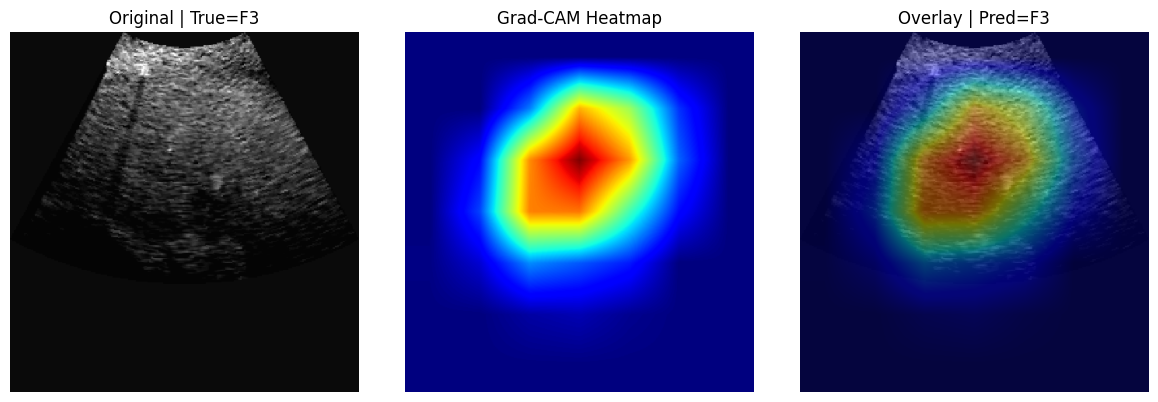

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# ==========================================================
# Your Grad-CAM class (same as yours)
# ==========================================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        self.model.eval()
        x = x.to(device)

        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        self.model.zero_grad(set_to_none=True)
        score = logits[:, class_idx].sum()
        score.backward(retain_graph=True)

        # activations: [B,C,H,W], gradients: [B,C,H,W]
        grads = self.gradients
        acts  = self.activations

        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        # Normalize per-image CAM
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-6)
        cam = cam.squeeze().detach().cpu().numpy()

        return cam, class_idx

# ==========================================================
# Better target-layer chooser for ResNet (timm)
# ==========================================================
def get_resnet_target_layer(model):
    """
    Works for timm resnet models.
    For resnet50/101/152 (Bottleneck), use layer4[-1].conv3
    For resnet18/34 (BasicBlock), use layer4[-1].conv2
    """
    # If the model has .layer4, pick last block's last conv
    if hasattr(model, "layer4"):
        last_block = model.layer4[-1]
        if hasattr(last_block, "conv3"):   # Bottleneck block (resnet50+)
            return last_block.conv3
        elif hasattr(last_block, "conv2"): # BasicBlock (resnet18/34)
            return last_block.conv2

    # fallback: last Conv2d in model
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, nn.Conv2d):
            print(f"[Fallback] Using last conv layer: {name}")
            return module
    return None

# ==========================================================
# Build Grad-CAM explainer on your trained resnet model
# ==========================================================
target_layer = get_resnet_target_layer(model)
print("Target layer:", target_layer)

cam_explainer = GradCAM(model, target_layer)

# ==========================================================
# Visualize one sample from your dataframe (df)
# Uses your val_tf, CLASS_NAMES, SEED, etc.
# ==========================================================
def show_gradcam_for_row(sample_row, class_idx=None, alpha=0.45):
    path = sample_row["path"]
    true_label = sample_row["label_name"]

    # Load original image
    img_np = np.array(Image.open(path).convert("RGB"))

    # Model input (same preprocessing as validation)
    img_in = val_tf(image=img_np)["image"].unsqueeze(0)

    # CAM
    cam, pred_idx = cam_explainer(img_in, class_idx=class_idx)
    pred_label = CLASS_NAMES[pred_idx]

    # Resize CAM to original image size
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title(f"Original | True={true_label}")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cam_resized, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img_np)
    plt.imshow(cam_resized, cmap="jet", alpha=alpha)
    plt.title(f"Overlay | Pred={pred_label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example: random sample
sample_row = df.sample(1, random_state=SEED).iloc[0]
show_gradcam_for_row(sample_row)

**Customized CNN**

Device: cuda


/tmp/ipykernel_55/3535810260.py:295: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Detected data root: /kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/
Total images: 6323
label_name
F0    2114
F1     861
F2     793
F3     857
F4    1698
Name: count, dtype: int64
Train: 5058 | Val: 1265

Train distribution:
 label_name
F0    1691
F1     689
F2     634
F3     686
F4    1358
Name: count, dtype: int64

Val distribution:
 label_name
F0    423
F1    172
F2    159
F3    171
F4    340
Name: count, dtype: int64


Epoch 1/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=1.3667 | val_acc=0.3352 | val_macroF1=0.2359 | val_auc=0.7095936686427068 | lr=1.00e-03


Epoch 2/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=1.3026 | val_acc=0.4182 | val_macroF1=0.3305 | val_auc=0.7061387933829081 | lr=1.00e-03


Epoch 3/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=1.2294 | val_acc=0.3083 | val_macroF1=0.2311 | val_auc=0.7019636598785033 | lr=1.00e-03


Epoch 4/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=1.2042 | val_acc=0.3968 | val_macroF1=0.2927 | val_auc=0.7517419729097762 | lr=1.00e-03


Epoch 5/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=1.1653 | val_acc=0.2395 | val_macroF1=0.1817 | val_auc=0.723544181285658 | lr=5.00e-04


Epoch 6/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=1.1545 | val_acc=0.5447 | val_macroF1=0.4461 | val_auc=0.8063548853524006 | lr=5.00e-04


Epoch 7/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=1.1320 | val_acc=0.4593 | val_macroF1=0.3755 | val_auc=0.7810713458113432 | lr=5.00e-04


Epoch 8/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=1.1049 | val_acc=0.4696 | val_macroF1=0.3801 | val_auc=0.8072543061700633 | lr=5.00e-04


Epoch 9/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09 | train_loss=1.0789 | val_acc=0.5676 | val_macroF1=0.4259 | val_auc=0.8330874124594564 | lr=2.50e-04


Epoch 10/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | train_loss=1.0616 | val_acc=0.5771 | val_macroF1=0.4973 | val_auc=0.8718011065537581 | lr=2.50e-04


Epoch 11/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11 | train_loss=1.0525 | val_acc=0.5447 | val_macroF1=0.4864 | val_auc=0.8513210274869009 | lr=2.50e-04


Epoch 12/12:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3535810260.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12 | train_loss=1.0319 | val_acc=0.6466 | val_macroF1=0.5755 | val_auc=0.8970108166072335 | lr=2.50e-04

Best Val Macro F1: 0.5755246354449521

=== Final Validation Metrics ===
Accuracy : 0.6466
Macro F1 : 0.5755
AUC (OvR): 0.8970108166072335

=== Classification Report ===
              precision    recall  f1-score   support

          F0     0.8896    0.9905    0.9374       423
          F1     0.4286    0.3314    0.3738       172
          F2     0.3323    0.6981    0.4503       159
          F3     0.6139    0.5673    0.5897       171
          F4     0.7929    0.3941    0.5265       340

    accuracy                         0.6466      1265
   macro avg     0.6115    0.5963    0.5755      1265
weighted avg     0.6936    0.6466    0.6421      1265



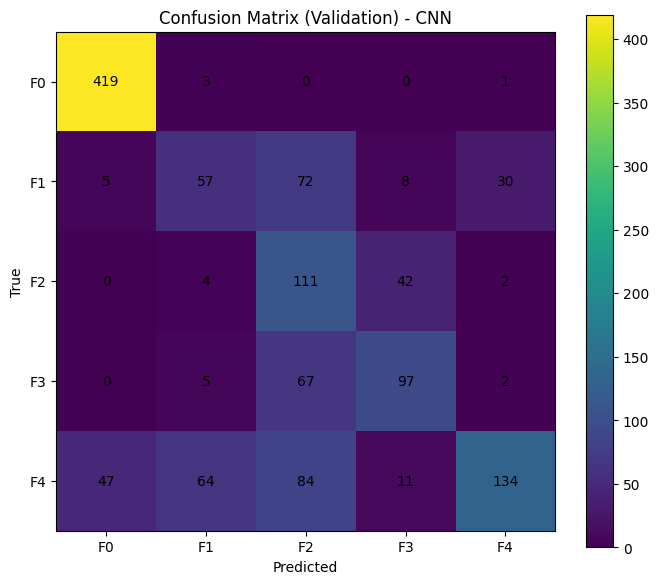

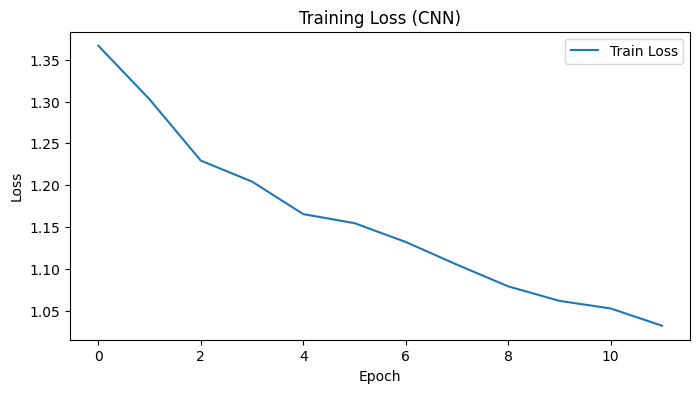

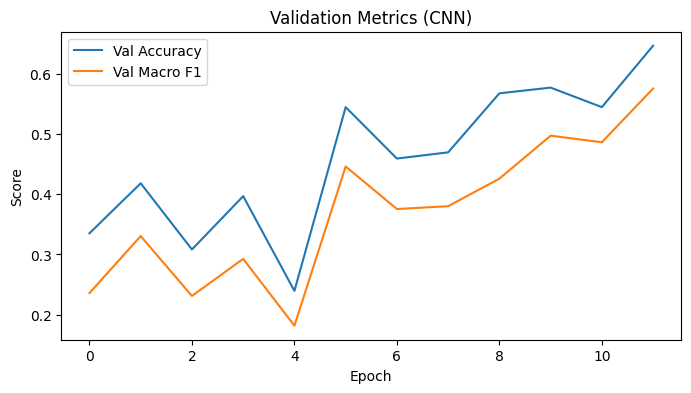

In [22]:
# =========================
# Liver Fibrosis Classification (Custom CNN, no CV)
# =========================

import os, glob, random
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# -------------------------
# Config
# -------------------------
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 12
LR = 1e-3
VAL_SIZE = 0.2

INPUT_ROOT = "/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset"
CLASS_NAMES = ["F0", "F1", "F2", "F3", "F4"]
CLASS_TO_ID = {c: i for i, c in enumerate(CLASS_NAMES)}

# -------------------------
# Seed
# -------------------------
def seed_all(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Find dataset root
# -------------------------
def find_data_root(base_root):
    candidates = glob.glob(os.path.join(base_root, "**"), recursive=True)
    for c in candidates:
        if os.path.isdir(c) and all(os.path.isdir(os.path.join(c, cls)) for cls in CLASS_NAMES):
            return c
    return None

data_root = find_data_root(INPUT_ROOT)
print("Detected data root:", data_root)
assert data_root is not None, "Could not find folder containing F0..F4"

# -------------------------
# Build dataframe
# -------------------------
def build_df(data_root):
    rows = []
    for cls in CLASS_NAMES:
        folder = os.path.join(data_root, cls)
        paths = []
        for ext in ["*.jpg", "*.JPG", "*.jpeg", "*.JPEG", "*.png", "*.PNG"]:
            paths.extend(glob.glob(os.path.join(folder, ext)))
        for p in paths:
            rows.append((p, CLASS_TO_ID[cls], cls))
    return pd.DataFrame(rows, columns=["path", "label", "label_name"])

df = build_df(data_root)
print("Total images:", len(df))
print(df["label_name"].value_counts().reindex(CLASS_NAMES))

# -------------------------
# Train / Val split (NO FOLDS)
# -------------------------
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SIZE,
    stratify=df["label"],
    random_state=SEED
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train: {len(train_df)} | Val: {len(val_df)}")
print("\nTrain distribution:\n", train_df["label_name"].value_counts().reindex(CLASS_NAMES))
print("\nVal distribution:\n", val_df["label_name"].value_counts().reindex(CLASS_NAMES))

# -------------------------
# Augmentations
# -------------------------
train_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Rotate(limit=7, p=0.5),
    A.RandomBrightnessContrast(p=0.35),
    A.GaussianBlur(blur_limit=(3, 5), p=0.15),
    A.ElasticTransform(alpha=10, sigma=6, p=0.15),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# -------------------------
# Dataset
# -------------------------
class LiverFibrosisDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        y = int(row["label"])

        img = cv2.imread(path)
        if img is None:
            img = np.array(Image.open(path).convert("RGB"))
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)["image"]

        return img, y

# -------------------------
# Custom CNN model
# -------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),      # 224 -> 112
            nn.Dropout(0.15),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),      # 112 -> 56
            nn.Dropout(0.20),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),      # 56 -> 28
            nn.Dropout(0.25),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),      # 28 -> 14
            nn.Dropout(0.30)
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.35),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

# -------------------------
# Helpers
# -------------------------
def compute_class_weights(labels, num_classes=5):
    counts = np.bincount(labels, minlength=num_classes).astype(np.float32)
    weights = 1.0 / np.maximum(counts, 1.0)
    weights = weights / weights.sum() * num_classes
    return torch.tensor(weights, dtype=torch.float32)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        probs = torch.softmax(logits, dim=1)

        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(torch.argmax(probs, dim=1).cpu().numpy().tolist())
        y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")

    auc = None
    try:
        y_bin = label_binarize(y_true, classes=list(range(len(CLASS_NAMES))))
        auc = roc_auc_score(y_bin, y_prob, average="macro", multi_class="ovr")
    except Exception:
        pass

    return acc, f1m, auc, y_true, y_pred, y_prob

# -------------------------
# DataLoaders (imbalance handling)
# -------------------------
train_ds = LiverFibrosisDataset(train_df, transform=train_tf)
val_ds = LiverFibrosisDataset(val_df, transform=val_tf)

labels = train_df["label"].values
class_counts = np.bincount(labels, minlength=len(CLASS_NAMES))
sample_weights = 1.0 / np.maximum(class_counts[labels], 1)

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, sampler=sampler,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

# -------------------------
# Model / optimizer / loss
# -------------------------
model = SimpleCNN(num_classes=len(CLASS_NAMES)).to(device)

class_w = compute_class_weights(train_df["label"].values, num_classes=len(CLASS_NAMES)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_w)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)

scaler = GradScaler()

# -------------------------
# Training loop
# -------------------------
best_f1 = -1.0
best_state = None
history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss = running_loss / len(train_ds)

    val_acc, val_f1, val_auc, y_true, y_pred, y_prob = evaluate(model, val_loader)
    scheduler.step(val_f1)

    history.append((train_loss, val_acc, val_f1, val_auc if val_auc is not None else np.nan))

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} | "
        f"val_acc={val_acc:.4f} | "
        f"val_macroF1={val_f1:.4f} | "
        f"val_auc={val_auc} | "
        f"lr={optimizer.param_groups[0]['lr']:.2e}"
    )

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# Load best weights
if best_state is not None:
    model.load_state_dict(best_state)

print("\nBest Val Macro F1:", best_f1)

# -------------------------
# Final evaluation
# -------------------------
val_acc, val_f1, val_auc, y_true, y_pred, y_prob = evaluate(model, val_loader)

print("\n=== Final Validation Metrics ===")
print(f"Accuracy : {val_acc:.4f}")
print(f"Macro F1 : {val_f1:.4f}")
print(f"AUC (OvR): {val_auc}")

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# -------------------------
# Confusion Matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation) - CNN")
plt.colorbar()
plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES)
plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()

# -------------------------
# Training curves
# -------------------------
hist = np.array(history, dtype=float)

plt.figure(figsize=(8, 4))
plt.plot(hist[:, 0], label="Train Loss")
plt.title("Training Loss (CNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(hist[:, 1], label="Val Accuracy")
plt.plot(hist[:, 2], label="Val Macro F1")
plt.title("Validation Metrics (CNN)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()



**Mobilenet v3**

Device: cuda
Detected data root: /kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/
Total images: 6323
label_name
F0    2114
F1     861
F2     793
F3     857
F4    1698
Name: count, dtype: int64
Train: 5058 | Val: 1265

Train distribution:
 label_name
F0    1691
F1     689
F2     634
F3     686
F4    1358
Name: count, dtype: int64

Val distribution:
 label_name
F0    423
F1    172
F2    159
F3    171
F4    340
Name: count, dtype: int64


model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

/tmp/ipykernel_55/3259964602.py:243: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3259964602.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=1.2996 | val_acc=0.7431 | val_macroF1=0.6934 | val_auc=0.9476776928861567 | lr=3.00e-04


Epoch 2/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3259964602.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.6651 | val_acc=0.7146 | val_macroF1=0.7216 | val_auc=0.9621056819622803 | lr=3.00e-04


Epoch 3/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3259964602.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.4739 | val_acc=0.8830 | val_macroF1=0.8424 | val_auc=0.9842954918156076 | lr=3.00e-04


Epoch 4/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3259964602.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.3101 | val_acc=0.9360 | val_macroF1=0.9103 | val_auc=0.9937123593994801 | lr=3.00e-04


Epoch 5/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3259964602.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.2586 | val_acc=0.9447 | val_macroF1=0.9291 | val_auc=0.9952594751468069 | lr=3.00e-04


Epoch 6/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3259964602.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.2234 | val_acc=0.9352 | val_macroF1=0.9232 | val_auc=0.9948780937265941 | lr=3.00e-04


Epoch 7/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3259964602.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1747 | val_acc=0.9621 | val_macroF1=0.9448 | val_auc=0.995158601485192 | lr=3.00e-04


Epoch 8/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3259964602.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.1040 | val_acc=0.9700 | val_macroF1=0.9572 | val_auc=0.9972756019627924 | lr=3.00e-04


Epoch 9/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3259964602.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09 | train_loss=0.1413 | val_acc=0.9692 | val_macroF1=0.9557 | val_auc=0.9973310581514869 | lr=3.00e-04


Epoch 10/10:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_55/3259964602.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | train_loss=0.0633 | val_acc=0.9747 | val_macroF1=0.9630 | val_auc=0.9982927274580448 | lr=3.00e-04

Best Val Macro F1: 0.9630370874707692

=== Final Validation Metrics ===
Accuracy : 0.9747
Macro F1 : 0.9630
AUC (OvR): 0.9982927274580448

=== Classification Report ===
              precision    recall  f1-score   support

          F0     1.0000    1.0000    1.0000       423
          F1     1.0000    0.9302    0.9639       172
          F2     0.9474    0.9057    0.9260       159
          F3     0.8973    0.9708    0.9326       171
          F4     0.9855    1.0000    0.9927       340

    accuracy                         0.9747      1265
   macro avg     0.9660    0.9613    0.9630      1265
weighted avg     0.9756    0.9747    0.9747      1265



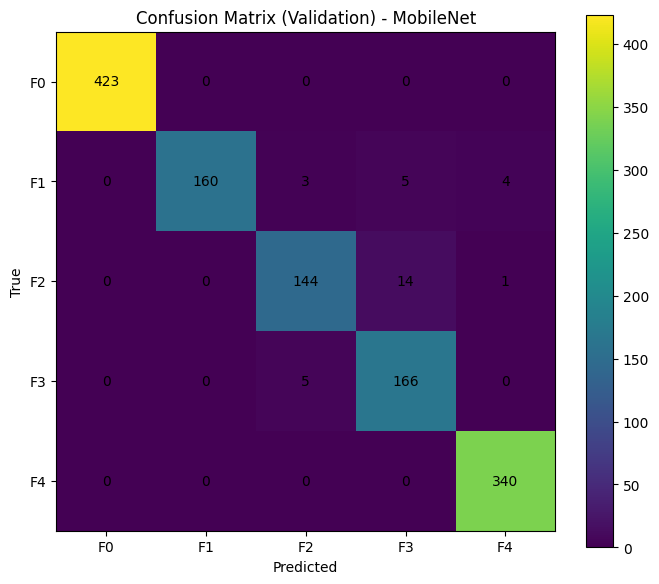

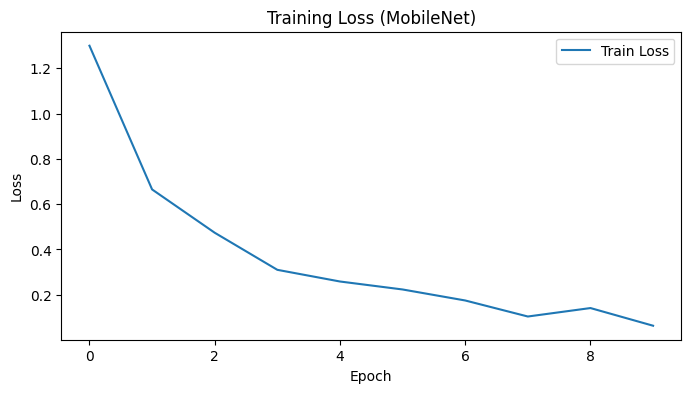

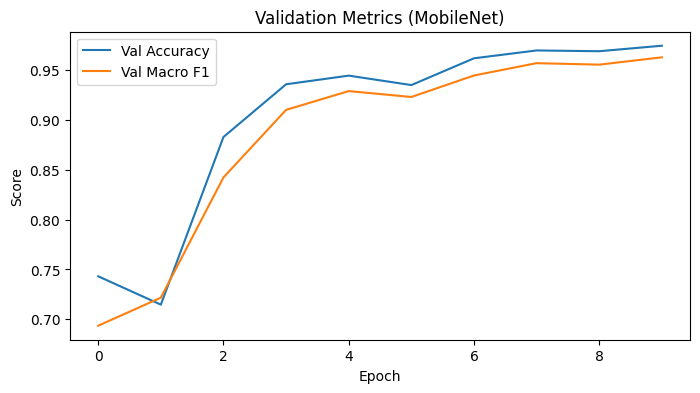

In [23]:
# =========================
# Liver Fibrosis Classification (MobileNet, no CV)
# =========================

import os, glob, random
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from tqdm import tqdm

# -------------------------
# Config
# -------------------------
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LR = 3e-4
VAL_SIZE = 0.2

MODEL_NAME = "mobilenetv3_large_100"   # other options: "mobilenetv3_small_100"
INPUT_ROOT = "/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset"

CLASS_NAMES = ["F0", "F1", "F2", "F3", "F4"]
CLASS_TO_ID = {c: i for i, c in enumerate(CLASS_NAMES)}

# -------------------------
# Seed
# -------------------------
def seed_all(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Find dataset root
# -------------------------
def find_data_root(base_root):
    candidates = glob.glob(os.path.join(base_root, "**"), recursive=True)
    for c in candidates:
        if os.path.isdir(c) and all(os.path.isdir(os.path.join(c, cls)) for cls in CLASS_NAMES):
            return c
    return None

data_root = find_data_root(INPUT_ROOT)
print("Detected data root:", data_root)
assert data_root is not None, "Could not find folder containing F0..F4"

# -------------------------
# Build dataframe
# -------------------------
def build_df(data_root):
    rows = []
    for cls in CLASS_NAMES:
        folder = os.path.join(data_root, cls)
        paths = []
        for ext in ["*.jpg", "*.JPG", "*.jpeg", "*.JPEG", "*.png", "*.PNG"]:
            paths.extend(glob.glob(os.path.join(folder, ext)))
        for p in paths:
            rows.append((p, CLASS_TO_ID[cls], cls))
    return pd.DataFrame(rows, columns=["path", "label", "label_name"])

df = build_df(data_root)
print("Total images:", len(df))
print(df["label_name"].value_counts().reindex(CLASS_NAMES))

# -------------------------
# Train / Val split (NO FOLDS)
# -------------------------
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SIZE,
    stratify=df["label"],
    random_state=SEED
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train: {len(train_df)} | Val: {len(val_df)}")
print("\nTrain distribution:\n", train_df["label_name"].value_counts().reindex(CLASS_NAMES))
print("\nVal distribution:\n", val_df["label_name"].value_counts().reindex(CLASS_NAMES))

# -------------------------
# Augmentations
# -------------------------
train_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Rotate(limit=7, p=0.5),
    A.RandomBrightnessContrast(p=0.35),
    A.GaussianBlur(blur_limit=(3, 5), p=0.15),
    A.ElasticTransform(alpha=10, sigma=6, p=0.15),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# -------------------------
# Dataset
# -------------------------
class LiverFibrosisDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        y = int(row["label"])

        img = cv2.imread(path)
        if img is None:
            img = np.array(Image.open(path).convert("RGB"))
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)["image"]

        return img, y

# -------------------------
# Model / helpers
# -------------------------
def build_model(model_name=MODEL_NAME, num_classes=5, pretrained=True):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    return model

def compute_class_weights(labels, num_classes=5):
    counts = np.bincount(labels, minlength=num_classes).astype(np.float32)
    weights = 1.0 / np.maximum(counts, 1.0)
    weights = weights / weights.sum() * num_classes
    return torch.tensor(weights, dtype=torch.float32)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        probs = torch.softmax(logits, dim=1)

        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(torch.argmax(probs, dim=1).cpu().numpy().tolist())
        y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")

    auc = None
    try:
        y_bin = label_binarize(y_true, classes=list(range(len(CLASS_NAMES))))
        auc = roc_auc_score(y_bin, y_prob, average="macro", multi_class="ovr")
    except Exception:
        pass

    return acc, f1m, auc, y_true, y_pred, y_prob

# -------------------------
# DataLoaders (imbalance handling)
# -------------------------
train_ds = LiverFibrosisDataset(train_df, transform=train_tf)
val_ds = LiverFibrosisDataset(val_df, transform=val_tf)

labels = train_df["label"].values
class_counts = np.bincount(labels, minlength=len(CLASS_NAMES))
sample_weights = 1.0 / np.maximum(class_counts[labels], 1)

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# -------------------------
# Train setup
# -------------------------
model = build_model(model_name=MODEL_NAME, num_classes=len(CLASS_NAMES), pretrained=True).to(device)

class_w = compute_class_weights(train_df["label"].values, num_classes=len(CLASS_NAMES)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_w)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)
scaler = GradScaler()

best_f1 = -1.0
best_state = None
history = []

# -------------------------
# Training loop
# -------------------------
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss = running_loss / len(train_ds)

    val_acc, val_f1, val_auc, y_true, y_pred, y_prob = evaluate(model, val_loader)
    scheduler.step(val_f1)

    history.append((train_loss, val_acc, val_f1, val_auc if val_auc is not None else np.nan))

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} | "
        f"val_acc={val_acc:.4f} | "
        f"val_macroF1={val_f1:.4f} | "
        f"val_auc={val_auc} | "
        f"lr={optimizer.param_groups[0]['lr']:.2e}"
    )

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)

print("\nBest Val Macro F1:", best_f1)

# -------------------------
# Final evaluation
# -------------------------
val_acc, val_f1, val_auc, y_true, y_pred, y_prob = evaluate(model, val_loader)

print("\n=== Final Validation Metrics ===")
print(f"Accuracy : {val_acc:.4f}")
print(f"Macro F1 : {val_f1:.4f}")
print(f"AUC (OvR): {val_auc}")

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# -------------------------
# Confusion Matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation) - MobileNet")
plt.colorbar()
plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES)
plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()

# -------------------------
# Training curves
# -------------------------
hist = np.array(history, dtype=float)

plt.figure(figsize=(8, 4))
plt.plot(hist[:, 0], label="Train Loss")
plt.title("Training Loss (MobileNet)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(hist[:, 1], label="Val Accuracy")
plt.plot(hist[:, 2], label="Val Macro F1")
plt.title("Validation Metrics (MobileNet)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()



In [24]:
import torch.nn as nn

def guess_target_layer(model):
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, nn.Conv2d):
            print("Using target layer:", name, module)
            return module
    return None

target_layer = guess_target_layer(model)
cam_explainer = GradCAM(model, target_layer)

Using target layer: conv_head Conv2d(960, 1280, kernel_size=(1, 1), stride=(1, 1))


**Dual Branch VIT**

Dual Branch VIT

Device: cuda
Detected data root: /kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/
Total images: 6323
label_name
F0    2114
F1     861
F2     793
F3     857
F4    1698
Name: count, dtype: int64
Train: 5058 | Val: 1265

Train distribution:
 label_name
F0    1691
F1     689
F2     634
F3     686
F4    1358
Name: count, dtype: int64

Val distribution:
 label_name
F0    423
F1    172
F2    159
F3    171
F4    340
Name: count, dtype: int64


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

/tmp/ipykernel_55/1866787154.py:306: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/317 [00:00<?, ?it/s]/tmp/ipykernel_55/1866787154.py:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=1.1638 | val_acc=0.6545 | val_macroF1=0.5577 | val_auc=0.9051042143311289 | lr=2.00e-04


Epoch 2/10:   0%|          | 0/317 [00:00<?, ?it/s]/tmp/ipykernel_55/1866787154.py:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.8967 | val_acc=0.7059 | val_macroF1=0.6502 | val_auc=0.937773307646155 | lr=2.00e-04


Epoch 3/10:   0%|          | 0/317 [00:00<?, ?it/s]/tmp/ipykernel_55/1866787154.py:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.7774 | val_acc=0.7399 | val_macroF1=0.6945 | val_auc=0.9396960260801169 | lr=2.00e-04


Epoch 4/10:   0%|          | 0/317 [00:00<?, ?it/s]/tmp/ipykernel_55/1866787154.py:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.6679 | val_acc=0.7992 | val_macroF1=0.7556 | val_auc=0.9673885520311891 | lr=2.00e-04


Epoch 5/10:   0%|          | 0/317 [00:00<?, ?it/s]/tmp/ipykernel_55/1866787154.py:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.5271 | val_acc=0.8704 | val_macroF1=0.8394 | val_auc=0.9826356414898438 | lr=2.00e-04


Epoch 6/10:   0%|          | 0/317 [00:00<?, ?it/s]/tmp/ipykernel_55/1866787154.py:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.4294 | val_acc=0.8996 | val_macroF1=0.8794 | val_auc=0.9856986190191728 | lr=2.00e-04


Epoch 7/10:   0%|          | 0/317 [00:00<?, ?it/s]/tmp/ipykernel_55/1866787154.py:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.3330 | val_acc=0.8996 | val_macroF1=0.8740 | val_auc=0.9879442337799903 | lr=2.00e-04


Epoch 8/10:   0%|          | 0/317 [00:00<?, ?it/s]/tmp/ipykernel_55/1866787154.py:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.2867 | val_acc=0.9241 | val_macroF1=0.9026 | val_auc=0.9904488040335409 | lr=2.00e-04


Epoch 9/10:   0%|          | 0/317 [00:00<?, ?it/s]/tmp/ipykernel_55/1866787154.py:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09 | train_loss=0.2571 | val_acc=0.9486 | val_macroF1=0.9293 | val_auc=0.992020180189096 | lr=2.00e-04


Epoch 10/10:   0%|          | 0/317 [00:00<?, ?it/s]/tmp/ipykernel_55/1866787154.py:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | train_loss=0.2221 | val_acc=0.9344 | val_macroF1=0.9188 | val_auc=0.9937296408657715 | lr=2.00e-04

Best Val Macro F1: 0.9293208399111537

=== Final Validation Metrics ===
Accuracy : 0.9486
Macro F1 : 0.9293
AUC (OvR): 0.992020180189096

=== Classification Report ===
              precision    recall  f1-score   support

          F0     0.9953    1.0000    0.9976       423
          F1     0.9864    0.8430    0.9091       172
          F2     0.7968    0.9371    0.8613       159
          F3     0.9217    0.8947    0.9080       171
          F4     0.9706    0.9706    0.9706       340

    accuracy                         0.9486      1265
   macro avg     0.9342    0.9291    0.9293      1265
weighted avg     0.9525    0.9486    0.9491      1265



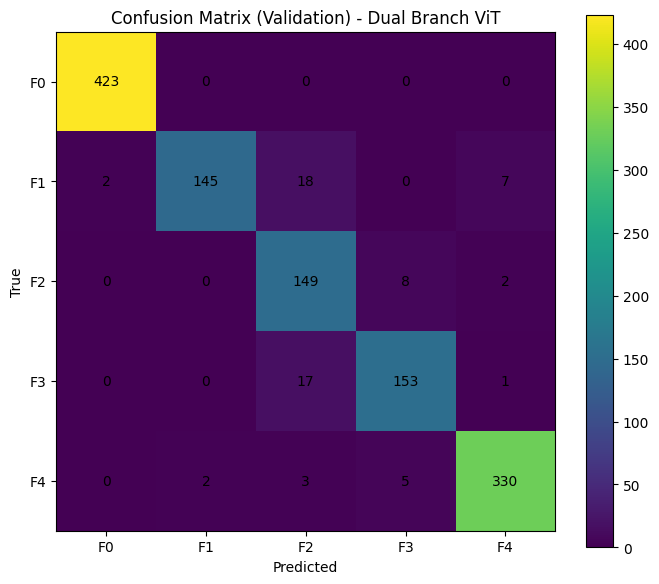

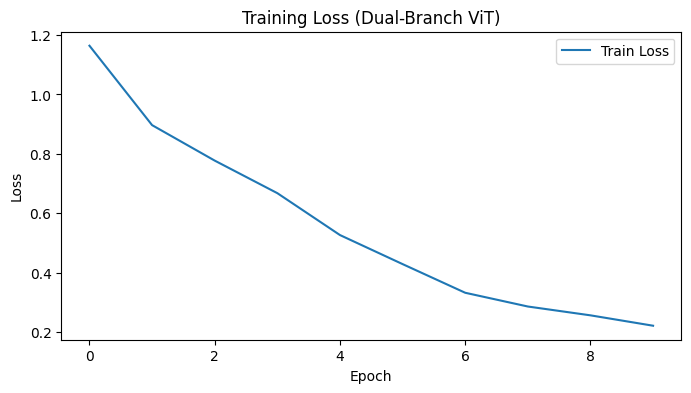

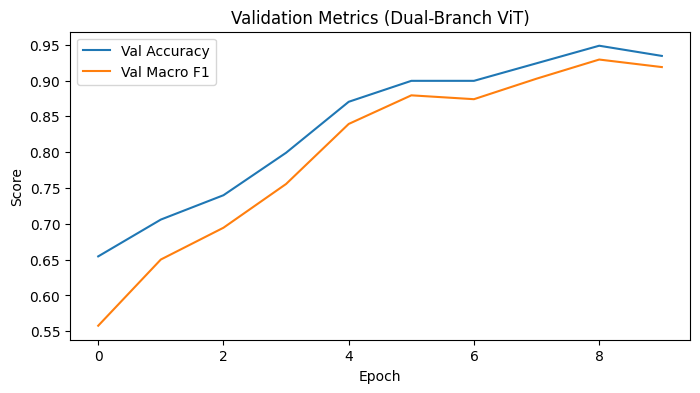

In [25]:
# =========================
# Liver Fibrosis Classification (Dual-Branch ViT, no CV)
# Branch-1: RGB image
# Branch-2: CLAHE-enhanced image
# =========================

import os, glob, random
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from tqdm import tqdm

# -------------------------
# Config
# -------------------------
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 16          # dual-ViT is memory heavy; use 8 if OOM
EPOCHS = 10
LR = 2e-4
VAL_SIZE = 0.2

# Good starting options:
# "vit_tiny_patch16_224", "deit_tiny_patch16_224", "vit_small_patch16_224"
VIT_NAME = "vit_tiny_patch16_224"

INPUT_ROOT = "/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset"
CLASS_NAMES = ["F0", "F1", "F2", "F3", "F4"]
CLASS_TO_ID = {c: i for i, c in enumerate(CLASS_NAMES)}

# -------------------------
# Seed
# -------------------------
def seed_all(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Find dataset root
# -------------------------
def find_data_root(base_root):
    candidates = glob.glob(os.path.join(base_root, "**"), recursive=True)
    for c in candidates:
        if os.path.isdir(c) and all(os.path.isdir(os.path.join(c, cls)) for cls in CLASS_NAMES):
            return c
    return None

data_root = find_data_root(INPUT_ROOT)
print("Detected data root:", data_root)
assert data_root is not None, "Could not find folder containing F0..F4"

# -------------------------
# Build dataframe
# -------------------------
def build_df(data_root):
    rows = []
    for cls in CLASS_NAMES:
        folder = os.path.join(data_root, cls)
        paths = []
        for ext in ["*.jpg", "*.JPG", "*.jpeg", "*.JPEG", "*.png", "*.PNG"]:
            paths.extend(glob.glob(os.path.join(folder, ext)))
        for p in paths:
            rows.append((p, CLASS_TO_ID[cls], cls))
    return pd.DataFrame(rows, columns=["path", "label", "label_name"])

df = build_df(data_root)
print("Total images:", len(df))
print(df["label_name"].value_counts().reindex(CLASS_NAMES))

# -------------------------
# Train / Val split (NO FOLDS)
# -------------------------
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SIZE,
    stratify=df["label"],
    random_state=SEED
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train: {len(train_df)} | Val: {len(val_df)}")
print("\nTrain distribution:\n", train_df["label_name"].value_counts().reindex(CLASS_NAMES))
print("\nVal distribution:\n", val_df["label_name"].value_counts().reindex(CLASS_NAMES))

# -------------------------
# Dual-branch transforms
# -------------------------
# Branch 1: regular RGB
train_tf_rgb = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Rotate(limit=7, p=0.5),
    A.RandomBrightnessContrast(p=0.35),
    A.GaussianBlur(blur_limit=(3, 5), p=0.15),
    A.ElasticTransform(alpha=10, sigma=6, p=0.15),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_tf_rgb = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Branch 2: slightly different augmentation stream (can be milder)
train_tf_aux = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Rotate(limit=5, p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_tf_aux = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# -------------------------
# CLAHE helper for second branch
# -------------------------
def apply_clahe_rgb(img_rgb):
    """
    img_rgb: uint8 RGB image (H,W,3)
    returns contrast-enhanced RGB image (uint8)
    """
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l2 = clahe.apply(l)
    img_lab2 = cv2.merge([l2, a, b])
    out_rgb = cv2.cvtColor(img_lab2, cv2.COLOR_LAB2RGB)
    return out_rgb

# -------------------------
# Dataset (returns two inputs)
# -------------------------
class DualBranchLiverDataset(Dataset):
    def __init__(self, df, tf_rgb=None, tf_aux=None):
        self.df = df.reset_index(drop=True)
        self.tf_rgb = tf_rgb
        self.tf_aux = tf_aux

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        y = int(row["label"])

        img = cv2.imread(path)
        if img is None:
            img_rgb = np.array(Image.open(path).convert("RGB"))
        else:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Branch 2 input: CLAHE-enhanced version
        img_aux = apply_clahe_rgb(img_rgb)

        x1 = self.tf_rgb(image=img_rgb)["image"] if self.tf_rgb else img_rgb
        x2 = self.tf_aux(image=img_aux)["image"] if self.tf_aux else img_aux

        return x1, x2, y

# -------------------------
# Dual-Branch ViT model
# -------------------------
class DualBranchViT(nn.Module):
    def __init__(self, vit_name="vit_tiny_patch16_224", num_classes=5, pretrained=True, dropout=0.3):
        super().__init__()

        # Each backbone outputs embedding features (no classifier head)
        self.branch1 = timm.create_model(
            vit_name, pretrained=pretrained, num_classes=0
        )
        self.branch2 = timm.create_model(
            vit_name, pretrained=pretrained, num_classes=0
        )

        feat_dim = self.branch1.num_features  # e.g., 192 for vit_tiny, 384 for vit_small

        self.fusion = nn.Sequential(
            nn.Linear(feat_dim * 2, feat_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(feat_dim, num_classes)
        )

    def forward(self, x1, x2):
        f1 = self.branch1(x1)   # [B, D]
        f2 = self.branch2(x2)   # [B, D]
        fused = torch.cat([f1, f2], dim=1)
        out = self.fusion(fused)
        return out

# -------------------------
# Helpers
# -------------------------
def compute_class_weights(labels, num_classes=5):
    counts = np.bincount(labels, minlength=num_classes).astype(np.float32)
    weights = 1.0 / np.maximum(counts, 1.0)
    weights = weights / weights.sum() * num_classes
    return torch.tensor(weights, dtype=torch.float32)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    for x1, x2, y in loader:
        x1 = x1.to(device, non_blocking=True)
        x2 = x2.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x1, x2)
        probs = torch.softmax(logits, dim=1)

        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(torch.argmax(probs, dim=1).cpu().numpy().tolist())
        y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")

    auc = None
    try:
        y_bin = label_binarize(y_true, classes=list(range(len(CLASS_NAMES))))
        auc = roc_auc_score(y_bin, y_prob, average="macro", multi_class="ovr")
    except Exception:
        pass

    return acc, f1m, auc, y_true, y_pred, y_prob

# -------------------------
# Datasets / DataLoaders
# -------------------------
train_ds = DualBranchLiverDataset(train_df, tf_rgb=train_tf_rgb, tf_aux=train_tf_aux)
val_ds   = DualBranchLiverDataset(val_df,   tf_rgb=val_tf_rgb,   tf_aux=val_tf_aux)

# imbalance handling
labels = train_df["label"].values
class_counts = np.bincount(labels, minlength=len(CLASS_NAMES))
sample_weights = 1.0 / np.maximum(class_counts[labels], 1)

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, sampler=sampler,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

# -------------------------
# Train setup
# -------------------------
model = DualBranchViT(vit_name=VIT_NAME, num_classes=len(CLASS_NAMES), pretrained=True).to(device)

class_w = compute_class_weights(train_df["label"].values, num_classes=len(CLASS_NAMES)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_w)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)
scaler = GradScaler()

best_f1 = -1.0
best_state = None
history = []

# -------------------------
# Training loop
# -------------------------
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for x1, x2, y in pbar:
        x1 = x1.to(device, non_blocking=True)
        x2 = x2.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = model(x1, x2)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x1.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss = running_loss / len(train_ds)

    val_acc, val_f1, val_auc, y_true, y_pred, y_prob = evaluate(model, val_loader)
    scheduler.step(val_f1)

    history.append((train_loss, val_acc, val_f1, val_auc if val_auc is not None else np.nan))

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} | "
        f"val_acc={val_acc:.4f} | "
        f"val_macroF1={val_f1:.4f} | "
        f"val_auc={val_auc} | "
        f"lr={optimizer.param_groups[0]['lr']:.2e}"
    )

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)

print("\nBest Val Macro F1:", best_f1)

# -------------------------
# Final evaluation
# -------------------------
val_acc, val_f1, val_auc, y_true, y_pred, y_prob = evaluate(model, val_loader)

print("\n=== Final Validation Metrics ===")
print(f"Accuracy : {val_acc:.4f}")
print(f"Macro F1 : {val_f1:.4f}")
print(f"AUC (OvR): {val_auc}")

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# -------------------------
# Confusion Matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation) - Dual Branch ViT")
plt.colorbar()
plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES)
plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()

# -------------------------
# Training curves
# -------------------------
hist = np.array(history, dtype=float)

plt.figure(figsize=(8, 4))
plt.plot(hist[:, 0], label="Train Loss")
plt.title("Training Loss (Dual-Branch ViT)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(hist[:, 1], label="Val Accuracy")
plt.plot(hist[:, 2], label="Val Macro F1")
plt.title("Validation Metrics (Dual-Branch ViT)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()



In [26]:
!pip -q install timm albumentations scikit-image

In [27]:
import os, glob, random, math, time
import numpy as np
import pandas as pd

from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.metrics import structural_similarity as ssim
from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

SEED = 42
def seed_all(seed=SEED):
    random.seed(seed); np.random.seed(seed); os.environ["PYTHONHASHSEED"]=str(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_all()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [28]:
DATASET_ROOTS = [
    "/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset",
    # "/kaggle/input/your-other-dataset/SomeFolder",
]

CLASS_NAMES = ["F0","F1","F2","F3","F4"]
CLASS_TO_ID = {c:i for i,c in enumerate(CLASS_NAMES)}
IMG_EXTS = (".jpg",".jpeg",".png",".bmp",".tif",".tiff",".JPG",".JPEG",".PNG")


In [29]:
def find_folders_with_classes(root):
    root = os.path.abspath(root)
    if all(os.path.isdir(os.path.join(root, c)) for c in CLASS_NAMES):
        return root
    candidates = glob.glob(os.path.join(root, "**"), recursive=True)
    for c in candidates:
        if os.path.isdir(c) and all(os.path.isdir(os.path.join(c, k)) for k in CLASS_NAMES):
            return c
    return None

resolved_roots = []
for r in DATASET_ROOTS:
    rr = find_folders_with_classes(r)
    print("Input:", r)
    print("Resolved:", rr)
    if rr is not None:
        resolved_roots.append(rr)

assert len(resolved_roots) > 0, "No valid dataset root found containing F0..F4."


Input: /kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset
Resolved: /kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset


In [30]:
def build_df_from_root(root):
    rows = []
    for cls in CLASS_NAMES:
        folder = os.path.join(root, cls)
        paths = []
        for ext in IMG_EXTS:
            paths += glob.glob(os.path.join(folder, f"*{ext}"))
        for p in paths:
            rows.append((p, CLASS_TO_ID[cls], cls, os.path.basename(root)))
    return pd.DataFrame(rows, columns=["path","label","label_name","source"])

df = pd.concat([build_df_from_root(r) for r in resolved_roots], ignore_index=True)
df = df.drop_duplicates(subset=["path"]).reset_index(drop=True)
print("Total images:", len(df))
df["label_name"].value_counts().reindex(CLASS_NAMES)


Total images: 6323


label_name
F0    2114
F1     861
F2     793
F3     857
F4    1698
Name: count, dtype: int64

label_name
F0    2114
F1     861
F2     793
F3     857
F4    1698
Name: count, dtype: int64

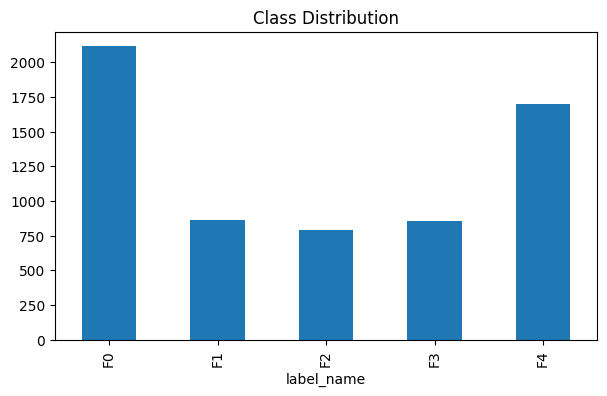

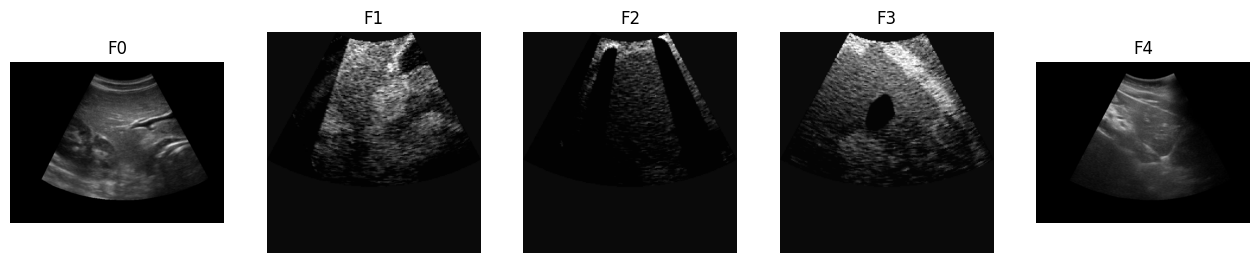

In [31]:
counts = df["label_name"].value_counts().reindex(CLASS_NAMES)
display(counts)

plt.figure(figsize=(7,4))
counts.plot(kind="bar"); plt.title("Class Distribution"); plt.show()

fig, axes = plt.subplots(1, 5, figsize=(16, 4))
for i, cls in enumerate(CLASS_NAMES):
    p = df[df["label_name"]==cls].sample(1, random_state=SEED)["path"].values[0]
    axes[i].imshow(Image.open(p).convert("RGB"))
    axes[i].set_title(cls); axes[i].axis("off")
plt.show()


In [32]:
IMG_SIZE = 224

def speckle_noise(img, sigma=0.12):
    x = img.astype(np.float32) / 255.0
    noise = np.random.randn(*x.shape).astype(np.float32) * sigma
    x = np.clip(x + x*noise, 0.0, 1.0)
    return (x * 255.0).astype(np.uint8)

class SpeckleNoise(A.ImageOnlyTransform):
    def __init__(self, sigma=0.12, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.sigma = sigma
    def apply(self, img, **params):
        return speckle_noise(img, self.sigma)

train_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Rotate(limit=7, border_mode=cv2.BORDER_REFLECT_101, p=0.5),
    A.ElasticTransform(alpha=10, sigma=6, alpha_affine=6, border_mode=cv2.BORDER_REFLECT_101, p=0.20),
    SpeckleNoise(sigma=0.12, p=0.5),
    A.RandomBrightnessContrast(p=0.30),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2(),
])

val_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2(),
])


/tmp/ipykernel_55/3354475733.py:19: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=10, sigma=6, alpha_affine=6, border_mode=cv2.BORDER_REFLECT_101, p=0.20),


In [33]:
DEDUP_CACHE = "/kaggle/working/dedup_keep_paths.csv"
IMG_SIZE_DEDUP = 224
MAX_IMAGES_FOR_DEDUP = None  # set 4000 for speed while testing

def read_img_bgr(path):
    img = cv2.imread(path)
    if img is None:
        img = np.array(Image.open(path).convert("RGB"))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def phash_cv2(img_bgr, hash_size=8, highfreq_factor=4):
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (hash_size*highfreq_factor, hash_size*highfreq_factor), interpolation=cv2.INTER_AREA)
    dct = cv2.dct(np.float32(img))
    dct_low = dct[:hash_size, :hash_size]
    med = np.median(dct_low[1:,1:])
    diff = dct_low > med
    return ''.join('1' if x else '0' for x in diff.flatten())

def compute_hashes(paths):
    rows=[]
    for p in tqdm(paths, desc="pHash"):
        try:
            img = read_img_bgr(p)
            h = phash_cv2(img)
            rows.append((p,h))
        except:
            continue
    return pd.DataFrame(rows, columns=["path","phash"])

def remove_dups_by_ssim(group_paths, threshold=0.98):
    kept, refs = [], []
    for p in group_paths:
        img = read_img_bgr(p)
        img = cv2.cvtColor(cv2.resize(img, (IMG_SIZE_DEDUP, IMG_SIZE_DEDUP)), cv2.COLOR_BGR2GRAY)
        if len(refs)==0:
            kept.append(p); refs.append(img); continue
        is_dup = False
        for r in refs:
            if ssim(img, r) >= threshold:
                is_dup = True
                break
        if not is_dup:
            kept.append(p); refs.append(img)
    return kept

if os.path.exists(DEDUP_CACHE):
    keep_paths = set(pd.read_csv(DEDUP_CACHE)["path"].tolist())
    df = df[df["path"].isin(keep_paths)].reset_index(drop=True)
    print("Loaded dedup cache. Remaining:", len(df))
else:
    work_df = df.copy()
    if MAX_IMAGES_FOR_DEDUP is not None and len(work_df) > MAX_IMAGES_FOR_DEDUP:
        work_df = work_df.sample(MAX_IMAGES_FOR_DEDUP, random_state=SEED).reset_index(drop=True)
        print("Dedup on subset:", len(work_df))

    hdf = compute_hashes(work_df["path"].tolist())
    merged = work_df.merge(hdf, on="path", how="inner")

    keep = []
    for ph, g in tqdm(merged.groupby("phash"), desc="SSIM groups"):
        paths = g["path"].tolist()
        keep += paths if len(paths)==1 else remove_dups_by_ssim(paths, threshold=0.98)

    keep = list(set(keep))
    pd.DataFrame({"path": keep}).to_csv(DEDUP_CACHE, index=False)
    if MAX_IMAGES_FOR_DEDUP is None:
        df = df[df["path"].isin(set(keep))].reset_index(drop=True)

    print("After dedup:", len(df))


SSIM groups: 100%|██████████| 1425/1425 [00:43<00:00, 32.79it/s]


After dedup: 1536


In [34]:
FEATURES_CACHE = "/kaggle/working/features_20_no_pyradiomics.csv"
R_COLS = [f"r_{i}" for i in range(20)]

def read_img_gray(path):
    img = cv2.imread(path)
    if img is None:
        img = np.array(Image.open(path).convert("L"))
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    return img

def default_roi_mask(h=224, w=224):
    mask = np.zeros((h,w), dtype=np.uint8)
    center = (w//2, h//2)
    axes = (int(w*0.35), int(h*0.30))
    cv2.ellipse(mask, center, axes, 0, 0, 360, 1, -1)
    return mask

def first_order_feats(x):
    mean = x.mean()
    var  = x.var()
    std  = x.std() + 1e-6
    skew = ((x-mean)**3).mean() / (std**3)
    kurt = ((x-mean)**4).mean() / (std**4)
    mn   = x.min()
    mx   = x.max()
    med  = np.median(x)
    iqr  = np.percentile(x, 75) - np.percentile(x, 25)
    hist, _ = np.histogram(x, bins=64, range=(0,255), density=True)
    hist = hist + 1e-12
    ent = -(hist*np.log(hist)).sum()
    eng = (hist**2).sum()
    return [mean, var, skew, kurt, ent, eng, mn, mx, med, iqr]  # 10

def glcm_feats(img_uint8):
    q = (img_uint8 / 8).astype(np.uint8)  # 0..31
    glcm = graycomatrix(q, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=32, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').mean()
    corr     = graycoprops(glcm, 'correlation').mean()
    homo     = graycoprops(glcm, 'homogeneity').mean()
    energy   = graycoprops(glcm, 'energy').mean()

    P = glcm[:, :, 0, :].mean(axis=2)  # avg angles -> [levels, levels]
    diff = np.zeros(32, dtype=np.float32)
    for i in range(32):
        for j in range(32):
            diff[abs(i-j)] += P[i,j]
    diff = diff + 1e-12
    diff_entropy = -(diff * np.log(diff)).sum()

    return [contrast, corr, homo, energy, diff_entropy]  # 5

def run_length_like_feats(img_uint8, mask):
    roi = img_uint8[mask==1]
    if roi.size < 10:
        return [0,0,0,0,0]

    q = (img_uint8 / 16).astype(np.uint8)  # 0..15
    runs, gray_levels = [], []

    for r in range(q.shape[0]):
        row = q[r,:]; mrow = mask[r,:]
        start = None
        for c in range(q.shape[1]):
            if mrow[c]==1 and start is None:
                start = c
            if (mrow[c]==0 or c==q.shape[1]-1) and start is not None:
                end = c if mrow[c]==0 else c+1
                segment = row[start:end]
                prev = segment[0]; runlen = 1
                for v in segment[1:]:
                    if v == prev:
                        runlen += 1
                    else:
                        runs.append(runlen); gray_levels.append(prev)
                        prev = v; runlen = 1
                runs.append(runlen); gray_levels.append(prev)
                start = None

    if len(runs)==0:
        return [0,0,0,0,0]

    runs = np.array(runs, dtype=np.float32)
    gray_levels = np.array(gray_levels, dtype=np.float32)

    SRE = np.mean(1.0/(runs+1e-6))              # short run emphasis
    LRE = np.mean(runs)                         # long run emphasis proxy
    GLN = np.var(gray_levels)                   # gray level non-uniformity proxy
    RLN = np.var(runs)                          # run length non-uniformity proxy
    RP  = len(runs) / (mask.sum() + 1e-6)       # run percentage proxy
    return [SRE, LRE, GLN, RLN, RP]

def extract_20_features(path):
    img = read_img_gray(path)
    mask = default_roi_mask(IMG_SIZE, IMG_SIZE)
    roi = img[mask==1].astype(np.float32)

    f1 = first_order_feats(roi)            # 10
    f2 = glcm_feats(img)                   # 5
    f3 = run_length_like_feats(img, mask)  # 5
    feats = np.array(f1+f2+f3, dtype=np.float32)
    feats = np.nan_to_num(feats, nan=0.0, posinf=0.0, neginf=0.0)
    return feats

if os.path.exists(FEATURES_CACHE):
    rdf = pd.read_csv(FEATURES_CACHE)
    print("Loaded features cache:", FEATURES_CACHE)
else:
    rows = []
    for p in tqdm(df["path"].tolist(), desc="Extract 20 features"):
        vec = extract_20_features(p)
        row = {"path": p}
        for i in range(20):
            row[f"r_{i}"] = float(vec[i])
        rows.append(row)
    rdf = pd.DataFrame(rows)
    rdf.to_csv(FEATURES_CACHE, index=False)
    print("Saved features cache:", FEATURES_CACHE)

df = df.merge(rdf, on="path", how="inner")
print("df shape after merging features:", df.shape)


Extract 20 features: 100%|██████████| 1536/1536 [00:42<00:00, 36.14it/s]

Saved features cache: /kaggle/working/features_20_no_pyradiomics.csv
df shape after merging features: (1536, 24)


In [35]:
if "stiffness_kpa" not in df.columns:
    stage = df["label"].values.astype(np.float32)
    df["stiffness_target"] = np.clip(stage + np.random.normal(0, 0.15, len(stage)).astype(np.float32), 0.0, 4.0)
else:
    df["stiffness_target"] = df["stiffness_kpa"].astype(np.float32)

df[["label_name","stiffness_target"]].head()


,label_name,stiffness_target
0,F0,0.074507
1,F0,0.000000
2,F0,0.097153
3,F0,0.228454
4,F0,0.000000


In [37]:
class MultiModalDataset(Dataset):
    def __init__(self, df, transform, scaler, stiffness_pred):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.scaler = scaler
        self.stiffness_pred = stiffness_pred  # aligned with df rows

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        y = int(row["label"])

        img = cv2.imread(path)
        if img is None:
            img = np.array(Image.open(path).convert("RGB"))
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = self.transform(image=img)["image"]

        r = row[R_COLS].values.astype(np.float32)
        r = self.scaler.transform(r.reshape(1,-1)).reshape(-1)

        stiff = np.float32(self.stiffness_pred[idx])
        tab = np.concatenate([r, [stiff]], axis=0).astype(np.float32)

        return img, torch.tensor(tab), y, np.float32(row["stiffness_target"])


In [38]:
class DualBranchViT(nn.Module):
    def __init__(self, vit_name="vit_small_patch16_224", tab_dim=21, num_classes=5, pretrained=True, attn_heads=8):
        super().__init__()
        self.vit = timm.create_model(vit_name, pretrained=pretrained, num_classes=0)
        self.embed_dim = self.vit.num_features

        self.tab_mlp = nn.Sequential(
            nn.Linear(tab_dim, 256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, self.embed_dim),
        )

        self.tab_to_img_attn = nn.MultiheadAttention(self.embed_dim, num_heads=attn_heads, batch_first=True)
        self.img_to_tab_attn = nn.MultiheadAttention(self.embed_dim, num_heads=attn_heads, batch_first=True)

        self.gate = nn.Sequential(
            nn.Linear(self.embed_dim*2, self.embed_dim),
            nn.GELU(),
            nn.Linear(self.embed_dim, 1)
        )

        self.cls_head = nn.Linear(self.embed_dim, num_classes)
        self.stiff_head = nn.Linear(self.embed_dim, 1)

    def forward_features_tokens(self, x):
        tokens = self.vit.forward_features(x)
        if tokens.dim() == 2:
            tokens = tokens.unsqueeze(1)
        return tokens

    def forward(self, img, tab):
        tokens = self.forward_features_tokens(img)  # [B,N,D]
        img_cls = tokens[:, :1, :]                  # [B,1,D]

        tab_tok = self.tab_mlp(tab).unsqueeze(1)    # [B,1,D]

        tab_ctx, _ = self.tab_to_img_attn(query=tab_tok, key=tokens, value=tokens)
        img_ctx, _ = self.img_to_tab_attn(query=img_cls, key=tab_tok, value=tab_tok)

        tab_ctx = tab_ctx.squeeze(1)
        img_ctx = img_ctx.squeeze(1)

        g = torch.sigmoid(self.gate(torch.cat([img_ctx, tab_ctx], dim=1)))  # [B,1]
        fused = g * img_ctx + (1 - g) * tab_ctx

        logits = self.cls_head(fused)
        stiff_pred = self.stiff_head(fused).squeeze(1)
        return logits, stiff_pred


In [39]:
def focal_loss_multiclass(logits, targets, gamma=2.0, alpha=None):
    ce = F.cross_entropy(logits, targets, reduction="none", weight=alpha)
    pt = torch.exp(-ce)
    return (((1-pt)**gamma) * ce).mean()

def bce_ovr_loss(logits, targets, pos_weight=None):
    C = logits.size(1)
    y = F.one_hot(targets, num_classes=C).float()
    return F.binary_cross_entropy_with_logits(logits, y, pos_weight=pos_weight)

def consistency_kl(p_logits, q_logits, temp=1.0):
    p = F.log_softmax(p_logits / temp, dim=1)
    q = F.softmax(q_logits / temp, dim=1)
    return F.kl_div(p, q, reduction="batchmean")


In [43]:
def make_class_weights(labels, num_classes=5):
    counts = np.bincount(labels, minlength=num_classes).astype(np.float32)
    w = 1.0 / np.maximum(counts, 1.0)
    w = w / w.sum() * num_classes
    return torch.tensor(w, dtype=torch.float32)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ys, yp, yprob = [], [], []

    for img, tab, y, stiff_t in loader:
        img = img.to(device); tab = tab.to(device); y = y.to(device)
        logits, sp = model(img, tab)
        probs = torch.softmax(logits, dim=1)

        ys.extend(y.cpu().numpy().tolist())
        yp.extend(torch.argmax(probs, dim=1).cpu().numpy().tolist())
        yprob.extend(probs.cpu().numpy())

    ys = np.array(ys); yp = np.array(yp); yprob = np.array(yprob)
    acc = accuracy_score(ys, yp)
    f1m = f1_score(ys, yp, average="macro")

    auc = None
    try:
        y_bin = label_binarize(ys, classes=list(range(5)))
        auc = roc_auc_score(y_bin, yprob, average="macro", multi_class="ovr")
    except:
        pass

    return acc, f1m, auc, ys, yp

def train_cv(df, n_splits=5, epochs=5, batch_size=16, lr=2e-4,
             vit_name="vit_small_patch16_224",
             lambda_focal=1.0, lambda_bce=0.25, lambda_smoothl1=0.30, lambda_consistency=0.15):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    fold_scores = []
    oof_true = np.zeros(len(df), dtype=int)
    oof_pred = np.zeros(len(df), dtype=int)

    for fold, (tr_idx, va_idx) in enumerate(skf.split(df, df["label"]), 1):
        print(f"\n================ Fold {fold}/{n_splits} ================")
        train_df = df.iloc[tr_idx].reset_index(drop=True)
        val_df   = df.iloc[va_idx].reset_index(drop=True)

        # scaler on train radiomics only (no leakage)
        scaler = StandardScaler()
        scaler.fit(train_df[R_COLS].values.astype(np.float32))

        # stiffness regressor on train only
        Xr = scaler.transform(train_df[R_COLS].values.astype(np.float32))
        yr = train_df["stiffness_target"].values.astype(np.float32)

        reg = RandomForestRegressor(n_estimators=200, random_state=SEED, n_jobs=-1)
        reg.fit(Xr, yr)

        train_stiff_pred = reg.predict(Xr).astype(np.float32)
        val_stiff_pred   = reg.predict(scaler.transform(val_df[R_COLS].values.astype(np.float32))).astype(np.float32)

        train_ds = MultiModalDataset(train_df, train_tf, scaler, train_stiff_pred)
        val_ds   = MultiModalDataset(val_df,   val_tf,   scaler, val_stiff_pred)

        labels = train_df["label"].values
        class_counts = np.bincount(labels, minlength=5)
        sample_w = 1.0 / np.maximum(class_counts[labels], 1)
        sampler = WeightedRandomSampler(torch.tensor(sample_w, dtype=torch.double),
                                        num_samples=len(sample_w), replacement=True)

        train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
        val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

        model = DualBranchViT(vit_name=vit_name, tab_dim=21, num_classes=5, pretrained=True, attn_heads=8).to(device)

        class_w = make_class_weights(labels, 5).to(device)
        posw = (class_counts.max() / np.maximum(class_counts,1)).astype(np.float32)
        posw = torch.tensor(posw, dtype=torch.float32).to(device)

        optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        scaler_amp = GradScaler()

        best_f1 = -1
        best_state = None

        for ep in range(1, epochs+1):
            model.train()
            running = 0.0

            for img, tab, y, stiff_t in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", leave=False):
                img = img.to(device); tab = tab.to(device); y = y.to(device); stiff_t = stiff_t.to(device)

                # cheap second view for consistency
                img2 = torch.flip(img, dims=[3])

                optim.zero_grad(set_to_none=True)
                with autocast():
                    logits1, stiff_pred1 = model(img, tab)
                    logits2, _           = model(img2, tab)

                    loss_f = focal_loss_multiclass(logits1, y, gamma=2.0, alpha=class_w)
                    loss_b = bce_ovr_loss(logits1, y, pos_weight=posw)
                    loss_r = F.smooth_l1_loss(stiff_pred1, stiff_t)
                    loss_c = consistency_kl(logits1, logits2, temp=1.0)

                    loss = (lambda_focal*loss_f +
                            lambda_bce*loss_b +
                            lambda_smoothl1*loss_r +
                            lambda_consistency*loss_c)

                scaler_amp.scale(loss).backward()
                scaler_amp.step(optim)
                scaler_amp.update()

                running += loss.item() * img.size(0)

            tr_loss = running / len(train_ds)
            acc, f1m, auc, _, _ = evaluate(model, val_loader)
            print(f"Epoch {ep:02d} | train_loss={tr_loss:.4f} | val_acc={acc:.4f} | val_macroF1={f1m:.4f} | val_auc={auc}")

            if f1m > best_f1:
                best_f1 = f1m
                best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}

        model.load_state_dict(best_state)
        acc, f1m, auc, ytrue, ypred = evaluate(model, val_loader)
        fold_scores.append((acc, f1m, auc))
        print(f"Fold {fold} FINAL | acc={acc:.4f} macroF1={f1m:.4f} auc={auc}")

        oof_true[va_idx] = ytrue
        oof_pred[va_idx] = ypred

    fold_scores = np.array([[a,f,(c if c is not None else np.nan)] for a,f,c in fold_scores], dtype=float)

    print("\n=== CV Summary ===")
    print("Mean acc    :", np.nanmean(fold_scores[:,0]))
    print("Mean macroF1:", np.nanmean(fold_scores[:,1]))
    print("Mean AUC    :", np.nanmean(fold_scores[:,2]))

    print("\nOOF Classification Report:")
    print(classification_report(oof_true, oof_pred, target_names=CLASS_NAMES))

    cm = confusion_matrix(oof_true, oof_pred)
    plt.figure(figsize=(6,5))
    plt.imshow(cm)
    plt.title("Confusion Matrix (OOF)")
    plt.xticks(range(5), CLASS_NAMES); plt.yticks(range(5), CLASS_NAMES)
    plt.colorbar(); plt.xlabel("Pred"); plt.ylabel("True")
    plt.show()

    return fold_scores



================ Fold 1/5 ================


/tmp/ipykernel_55/3459043582.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = GradScaler()
Epoch 1/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=0.7385 | val_acc=0.5584 | val_macroF1=0.5602 | val_auc=0.8597181360984196


Epoch 2/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.2674 | val_acc=0.6006 | val_macroF1=0.5907 | val_auc=0.8763641443833092


Epoch 3/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.1875 | val_acc=0.5617 | val_macroF1=0.5706 | val_auc=0.8688158470674068


Epoch 4/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.1999 | val_acc=0.5032 | val_macroF1=0.5144 | val_auc=0.8429726405030415


Epoch 5/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.2053 | val_acc=0.5552 | val_macroF1=0.5585 | val_auc=0.8630931114277416


Epoch 6/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.1708 | val_acc=0.5844 | val_macroF1=0.5827 | val_auc=0.8624341683916565


Epoch 7/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1253 | val_acc=0.6071 | val_macroF1=0.5987 | val_auc=0.875554382295282


Epoch 8/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.1309 | val_acc=0.5617 | val_macroF1=0.5678 | val_auc=0.858471541978145


Epoch 9/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09 | train_loss=0.1342 | val_acc=0.5617 | val_macroF1=0.5588 | val_auc=0.8519135173180258


Epoch 10/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | train_loss=0.1225 | val_acc=0.5812 | val_macroF1=0.5816 | val_auc=0.86831843793244
Fold 1 FINAL | acc=0.6071 macroF1=0.5987 auc=0.875554382295282

================ Fold 2/5 ================


/tmp/ipykernel_55/3459043582.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = GradScaler()
Epoch 1/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=0.6915 | val_acc=0.5635 | val_macroF1=0.5291 | val_auc=0.8390319709314304


Epoch 2/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.2117 | val_acc=0.5212 | val_macroF1=0.4714 | val_auc=0.8137550185443315


Epoch 3/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.2340 | val_acc=0.5570 | val_macroF1=0.5520 | val_auc=0.8302229535534783


Epoch 4/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.1841 | val_acc=0.5342 | val_macroF1=0.5342 | val_auc=0.8200568154141388


Epoch 5/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.1853 | val_acc=0.4919 | val_macroF1=0.4870 | val_auc=0.8206276142277927


Epoch 6/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.1683 | val_acc=0.5603 | val_macroF1=0.5572 | val_auc=0.8364393071363561


Epoch 7/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1695 | val_acc=0.5700 | val_macroF1=0.5746 | val_auc=0.8258373830763475


Epoch 8/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.1519 | val_acc=0.5342 | val_macroF1=0.5325 | val_auc=0.8215142172548433


Epoch 9/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09 | train_loss=0.1345 | val_acc=0.5342 | val_macroF1=0.5345 | val_auc=0.8245034026263124


Epoch 10/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | train_loss=0.1190 | val_acc=0.5407 | val_macroF1=0.5403 | val_auc=0.8267701877071925
Fold 2 FINAL | acc=0.5700 macroF1=0.5746 auc=0.8258373830763475

================ Fold 3/5 ================


/tmp/ipykernel_55/3459043582.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = GradScaler()
Epoch 1/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=0.7519 | val_acc=0.5212 | val_macroF1=0.5155 | val_auc=0.8028190378416342


Epoch 2/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.2727 | val_acc=0.5147 | val_macroF1=0.5108 | val_auc=0.8114462369178634


Epoch 3/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.1773 | val_acc=0.5016 | val_macroF1=0.5025 | val_auc=0.7949622544393395


Epoch 4/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.2122 | val_acc=0.5244 | val_macroF1=0.5204 | val_auc=0.8075381345923016


Epoch 5/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.2096 | val_acc=0.5081 | val_macroF1=0.5065 | val_auc=0.7954357914675414


Epoch 6/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.1804 | val_acc=0.5407 | val_macroF1=0.5283 | val_auc=0.8109349704298268


Epoch 7/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1291 | val_acc=0.5375 | val_macroF1=0.5330 | val_auc=0.8148067249541789


Epoch 8/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.1631 | val_acc=0.5277 | val_macroF1=0.5109 | val_auc=0.8167701890531751


Epoch 9/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09 | train_loss=0.1354 | val_acc=0.5179 | val_macroF1=0.5052 | val_auc=0.8085146429195064


Epoch 10/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | train_loss=0.1393 | val_acc=0.5244 | val_macroF1=0.5242 | val_auc=0.8141242355825888
Fold 3 FINAL | acc=0.5375 macroF1=0.5330 auc=0.8148067249541789

================ Fold 4/5 ================


/tmp/ipykernel_55/3459043582.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = GradScaler()
Epoch 1/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=0.6453 | val_acc=0.5407 | val_macroF1=0.5315 | val_auc=0.8489176322419114


Epoch 2/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.2880 | val_acc=0.5798 | val_macroF1=0.5715 | val_auc=0.8437704495681707


Epoch 3/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.2044 | val_acc=0.5700 | val_macroF1=0.5688 | val_auc=0.8449650321066706


Epoch 4/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.1521 | val_acc=0.6026 | val_macroF1=0.6036 | val_auc=0.8619401441978661


Epoch 5/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.1548 | val_acc=0.5765 | val_macroF1=0.5831 | val_auc=0.8653730547469133


Epoch 6/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.1402 | val_acc=0.6319 | val_macroF1=0.6176 | val_auc=0.8584538586519794


Epoch 7/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1241 | val_acc=0.6189 | val_macroF1=0.6172 | val_auc=0.869077033869457


Epoch 8/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.1571 | val_acc=0.5765 | val_macroF1=0.5712 | val_auc=0.8585694864405546


Epoch 9/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09 | train_loss=0.1395 | val_acc=0.6026 | val_macroF1=0.6087 | val_auc=0.8591805594456347


Epoch 10/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | train_loss=0.1330 | val_acc=0.5798 | val_macroF1=0.5579 | val_auc=0.8637988671779665
Fold 4 FINAL | acc=0.6319 macroF1=0.6176 auc=0.8584538586519794

================ Fold 5/5 ================


/tmp/ipykernel_55/3459043582.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = GradScaler()
Epoch 1/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | train_loss=0.6897 | val_acc=0.5537 | val_macroF1=0.5492 | val_auc=0.8268942801275425


Epoch 2/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | train_loss=0.2623 | val_acc=0.4951 | val_macroF1=0.4994 | val_auc=0.8247282228458177


Epoch 3/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | train_loss=0.2105 | val_acc=0.5407 | val_macroF1=0.5313 | val_auc=0.8326001143067419


Epoch 4/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | train_loss=0.1917 | val_acc=0.5472 | val_macroF1=0.5440 | val_auc=0.8293448567567043


Epoch 5/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | train_loss=0.1699 | val_acc=0.5016 | val_macroF1=0.5039 | val_auc=0.8241007838157388


Epoch 6/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | train_loss=0.1537 | val_acc=0.5342 | val_macroF1=0.5253 | val_auc=0.8358540551748117


Epoch 7/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | train_loss=0.1383 | val_acc=0.4756 | val_macroF1=0.4783 | val_auc=0.8261409223233166


Epoch 8/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | train_loss=0.1317 | val_acc=0.5179 | val_macroF1=0.5247 | val_auc=0.8271109193756183


Epoch 9/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09 | train_loss=0.1535 | val_acc=0.5570 | val_macroF1=0.5590 | val_auc=0.8369996417907647


Epoch 10/10:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_55/3459043582.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | train_loss=0.1126 | val_acc=0.5537 | val_macroF1=0.5446 | val_auc=0.8322447589179367
Fold 5 FINAL | acc=0.5570 macroF1=0.5590 auc=0.8369996417907647

=== CV Summary ===
Mean acc    : 0.5807119590507213
Mean macroF1: 0.5765861492487849
Mean AUC    : 0.8423303981537107

OOF Classification Report:
              precision    recall  f1-score   support

          F0       0.88      0.79      0.83       317
          F1       0.46      0.36      0.41       296
          F2       0.47      0.59      0.52       308
          F3       0.50      0.64      0.56       308
          F4       0.67      0.50      0.57       307

    accuracy                           0.58      1536
   macro avg       0.59      0.58      0.58      1536
weighted avg       0.60      0.58      0.58      1536



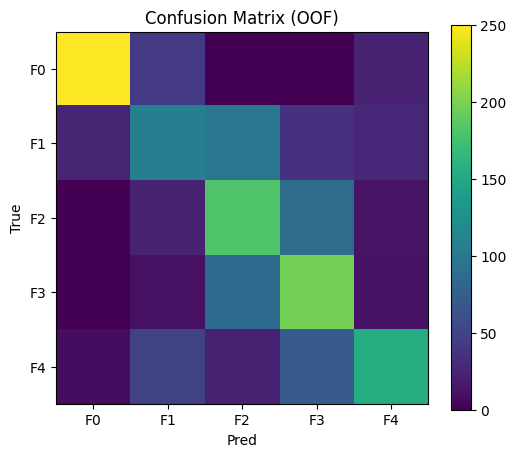

array([[0.60714286, 0.5987455 , 0.87555438],
       [0.57003257, 0.57455483, 0.82583738],
       [0.53745928, 0.53301695, 0.81480672],
       [0.63192182, 0.61760756, 0.85845386],
       [0.55700326, 0.5590059 , 0.83699964]])

In [46]:
scores = train_cv(
    df,
    n_splits=5,
    epochs=10,          # increase to 10–20 for stronger results
    batch_size=16,     # if OOM -> 8
    lr=2e-4,
    vit_name="vit_small_patch16_224"  # smaller + faster than vit_base
)

scores